# Load Libraries and Functions

In [26]:
# System, Data, Time, and Spec Libraries
import os
import pandas as pd
import time
import random
from datetime import datetime, timedelta
import numpy as np 
from line_profiler import LineProfiler  # Code peformance
profiler = LineProfiler()
import warnings
warnings.filterwarnings('ignore')
import csv
#pd.set_option('display.max_colwidth', None)
import multiprocess as mp
num_cores = mp.cpu_count()

# Data Visualization Libraries
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.express as px
import seaborn as sns
#from pandas.io.json import json_normalize  # Older version
from pandas import json_normalize  # Newer version


# Natural Language Processing Libraries
import json
import requests
import xml.etree.ElementTree as ET
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams
from nltk.corpus import stopwords
from string import punctuation
punctuation = set(punctuation)
punctuation.update({'_', '-','‘'})
english_words = set(words.words())
from fuzzywuzzy import process
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('stopwords')

# SQL Interface Libraries
import pymysql as mysql
import mysql.connector
import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from string import punctuation

# Importing Custom Functions
import nbimporter
from Functions import process_text, add_sequential_index, process_label_text, remove_duplicates_nan
from Functions import classify_product_type, nan_info, plot_character_length, convert_to_years, examine_text_outliers
from Functions import process_company_text, clean_manufacturer_text, clean_data, list_to_string


### Test Multiprocessing with Script

In [27]:
def f(x):
    return x*x

# should add if __name__ == '__main__': protection to protect against infinite process creation
if __name__ == '__main__':
    with mp.Pool(5) as pool:
        print(pool.map(f, [1, 2, 3, 4, 5]))

[1, 4, 9, 16, 25]


# API Keys and Passwords

In [28]:
# MySQL password
PASSWORD = "LunarLanding$"  # Your Password

# openFDA API Key
openFDAAPI = "E9AA90Q9ntbRnUu0MuXGVPchoquUCFgNhbmZ8pOk"  # Halee
openFDAAPIVicky = "hIh9QVHxR5GsP8A8ffDcoDt2MMRWh3SjeeCV9joF" # Vicky
# Data.Medicaid API Key

In [29]:
# Code to assess performance
# Still need to implement
#from line_profiler import LineProfiler

#def your_function():
    # Your code here


#profiler.add_function(your_function)
#profiler.run('your_function()')
#profiler.print_stats()

# FDA Data

## API Request for Historical Text Documents

https://open.fda.gov/apis/other/historicaldocument/

In [30]:
# Time API call
start_time = time.time() 

# OpenFDA API endpoint for fetching historical documents
BASE_URL = 'https://api.fda.gov/other/historicaldocument.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the API request
params = {
    'limit': 1000,  # Adjust the limit as needed
    'skip': 0,       # Starting point for fetching records
    'search': "year:2009 + year:2010 + year:2011 + year:2012 + year:2013 + year:2014"  # Adjust year as needed
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data():
    documents = []
    
    while True:
        headers = {
            'Authorization': f'Bearer {API_KEY}'
        }
        response = requests.get(BASE_URL, params=params, headers=headers)

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")
            break

        for item in results:
            doc_type = item.get('doc_type', 'N/A')
            year = item.get('year', 'N/A')
            text = item.get('text', 'N/A')
            document = {'doc_type': doc_type, 'year': year, 'text': text}
            if document not in documents:
                documents.append(document)
        
        params['skip'] += params['limit']
        pause_execution()

        print('.', end='', flush=True)

    return documents

# Fetch the data
documents = fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time}")


..Failed to fetch data: 404

Request Time: 31.105432510375977


In [31]:
# Save the data to a dataframe
documents_df = pd.DataFrame(documents)
documents_df.head()

,doc_type,year,text
0,pr,2014,FDA NEWS RELEASE\nFor Immediate Release: April...
1,pr,2014,FDA NEWS RELEASE\n\nFor Immediate Release: Apr...
2,pr,2013,FDA NEWS RELEASE\n\nFor Immediate Release: Jul...
3,pr,2013,FDA NEWS RELEASE\n\nFor Immediate Release: Jul...
4,pr,2014,FDA NEWS RELEASE\n\nFor Immediate Release: Apr...


In [32]:
# 8854 documents at time of project creation
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222 entries, 0 to 1221
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doc_type  1222 non-null   object
 1   year      1222 non-null   int64 
 2   text      1222 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.8+ KB


In [33]:
# Save csv file to data library
#csv_file_path = 'DataLibrary/raw_documents.csv'
#documents_df.to_csv(csv_file_path, index=False)

## API Request for Adverse Events Data

https://open.fda.gov/apis/drug/event/

In [34]:
# Time the API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug event data
BASE_URL = 'https://api.fda.gov/drug/event.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the initial API request
# Adjust search terms to filter/limit data
params = {
    'limit': 100,  # Maximum limit per request
    'search': '_exists_:patient.reaction.reactionoutcome AND patient.drug.drugcharacterization:1 AND patient.patientsex:>0 AND primarysource.qualification:<4 AND patient.reaction.reactionoutcome:<6 AND _exists_:patient.patientweight AND _exists_:patient.patientonsetage AND receiptdate:[2024-01-23 TO 2024-04-23]'
}

# Output file path outside of GitHub/Jupyter due to large file size
# Update file name based on data specs
# File will be called from local storage in subsequent code
#OUTPUT_FILE = os.path.join('DataLibrary', 'drug_events2024.json')

OUTPUT_FILE = os.path.join(os.environ['USERPROFILE'], 'Downloads', 'drug_events2024.json')

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())
    
# Function to fetch data from the OpenFDA API using the Search-After mechanism
def fetch_data():
    next_url = None
    count = 0
    
    # Open the file in write mode and write the header
    with open(OUTPUT_FILE, mode='w') as file:
        first_chunk = True
        while True:
            headers = {
                'Authorization': f'Bearer {API_KEY}'
            }
            if next_url:
                response = requests.get(next_url, headers=headers)
            else:
                response = requests.get(BASE_URL, params=params, headers=headers)
            if response.status_code != 200:
                print(f"Failed to fetch data: {response.status_code}")
                break
            data = response.json()
            results = data.get('results', [])
            if not results:
                print("No more results found.")
                break
            
            # Write the data to JSON incrementally
            if first_chunk:
                json.dump(results, file)
                first_chunk = False
            else:
                file.write('\n')
                json.dump(results, file)
            count += len(results)
            
            # Extract the next URL from the Link header
            next_url = None
            link_header = response.headers.get('Link')
            if link_header:
                links = link_header.split(',')
                for link in links:
                    if 'rel="next"' in link:
                        next_url = link[link.find('<') + 1:link.find('>')]
                        break
            if not next_url:
                print("No more pages found.")
                break
            pause_execution()
            print('.', end='', flush=True)  # Dots will show progress
    
    print(f"\nTotal records fetched: {count}")
    return OUTPUT_FILE

# Fetch the data and save it incrementally to a JSON file
fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

................................................................................................................................................................................................................No more pages found.

Total records fetched: 20885

Request Time: 683.5405812263489 seconds


In [35]:
# Read in .json file in chunks
start_time = time.time()

# Path to the JSON file
#file_path = os.path.join('DataLibrary', 'drug_events2023.json')
file_path = os.path.join(os.path.expanduser('~'), 'Downloads', 'drug_events2024.json')


# Initialize an empty list to store DataFrames
dfs = []

# Function to read JSON file in chunks
def read_json_in_chunks(file_path, chunk_size=10000):
    with open(file_path, 'r') as file:
        chunk = []
        for line in file:
            try:
                data = json.loads(line)
                chunk.extend(data)
                if len(chunk) >= chunk_size:
                    yield chunk
                    chunk = []
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {file.tell()}: {e}")
        if chunk:
            yield chunk

# Read the JSON file in chunks and process
for chunk in read_json_in_chunks(file_path):
    dfs.append(pd.json_normalize(chunk))

# Concatenate all DataFrames
events2024_df = pd.concat(dfs, ignore_index=True)

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

# Clean up temporary df list to preserve ram memory
del dfs


Request Time: 42.92739152908325 seconds


In [36]:
# Check dataframe size
events2024_df.shape

(20885, 40)

In [37]:
events2024_df.head()

,safetyreportversion,safetyreportid,primarysourcecountry,occurcountry,transmissiondateformat,transmissiondate,reporttype,serious,seriousnessdeath,seriousnesslifethreatening,...,patient.patientonsetageunit,patient.patientweight,patient.patientsex,patient.reaction,patient.drug,patient.summary.narrativeincludeclinical,reportduplicate,primarysource.literaturereference,patient.patientagegroup,authoritynumb
0,72,10136162,CA,CA,102,20240409,3,1,2,2,...,801,112,2,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20120821,NaN,NaN,NaN,NaN
1,16,10142803,CA,CA,102,20240409,3,1,2,2,...,801,74,1,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20130101,"[{'duplicatesource': '002147023', 'duplicatenu...",NaN,NaN,NaN
2,2,10153990,US,US,102,20240410,2,1,2,2,...,801,61.22,2,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20140301,NaN,NaN,NaN,NaN
3,33,10175722,CA,NaN,102,20240410,3,1,2,2,...,801,57,2,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20121201,NaN,NaN,NaN,NaN
4,19,10209590,CA,NaN,102,20240410,3,1,2,2,...,801,50,2,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20140521,NaN,NaN,NaN,NaN


In [38]:
# Check missing info
nan_info(events2024_df)

,column_name,null_count,null_proportion
0,safetyreportversion,0,0.000000
1,safetyreportid,0,0.000000
2,primarysourcecountry,31,0.148432
3,occurcountry,1539,7.368925
4,transmissiondateformat,0,0.000000
5,transmissiondate,0,0.000000
6,reporttype,2,0.009576
7,serious,0,0.000000
8,seriousnessdeath,925,4.429016
9,seriousnesslifethreatening,682,3.265502


In [39]:
## ONLY USED FOR BETA TESTING Of SMALL SAMPLE ######
# Save the sample data to a CSV file
#csv_file_path = 'DataLibrary/raw_events.csv'
#events_df.to_csv(csv_file_path, index=False)
#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Drug Labels

https://open.fda.gov/apis/drug/label/

In [40]:
# Time API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug label data
BASE_URL = 'https://api.fda.gov/drug/label.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the initial API request
params = {
     'limit': 100,  # Maximum limit per request
     'search': 'effective_time:[2023-01-01 TO 2024-04-23]'  # Adjust to match date range of FAERS data
}

# Output file path for saving the data
OUTPUT_FILE = os.path.join(os.path.expanduser('~'), 'Downloads', 'drug_labels2024.json')
# OUTPUT_FILE = os.path.join('DataLibrary', 'drug_labels2022.json')

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API using the Search-After mechanism
def fetch_data():
    next_url = None
    count = 0
    
    # Open the file in write mode and write the header
    with open(OUTPUT_FILE, mode='w') as file:
        first_chunk = True
        while True:
            headers = {
                'Authorization': f'Bearer {API_KEY}'
            }
            if next_url:
                response = requests.get(next_url, headers=headers)
            else:
                response = requests.get(BASE_URL, params=params, headers=headers)
            if response.status_code != 200:
                print(f"Failed to fetch data: {response.status_code}")
                break
            data = response.json()
            results = data.get('results', [])
            if not results:
                print("No more results found.")
                break
            
            # Write the data to JSON incrementally
            if first_chunk:
                json.dump(results, file)
                first_chunk = False
            else:
                file.write('\n')
                json.dump(results, file)
            count += len(results)
            
            # Extract the next URL from the Link header
            next_url = None
            link_header = response.headers.get('Link')
            if link_header:
                links = link_header.split(',')
                for link in links:
                    if 'rel="next"' in link:
                        next_url = link[link.find('<') + 1:link.find('>')]
                        break
            if not next_url:
                print("No more pages found.")
                break
            pause_execution()
            print('.', end='', flush=True)  # Dots will show progress
    
    print(f"\nTotal records fetched: {count}")
    return OUTPUT_FILE

# Fetch the data and save it incrementally to a JSON file
fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................No more pages found.

Total records fetched: 59052

Request Time: 944.4990127086639 seconds


In [41]:
# Read in .json file in chunks
start_time = time.time()

# Path to the JSON file
#file_path_labels = os.path.join('DataLibrary', 'drug_labels2022.json')
file_path_labels = os.path.join(os.path.expanduser('~'), 'Downloads', 'drug_labels2024.json')

# Initialize an empty list to store DataFrames
dfs_labels = []

# Function to read JSON file in chunks
def read_json_in_chunks(file_path, chunk_size=10000):
    with open(file_path, 'r') as file:
        chunk = []
        for line in file:
            try:
                data = json.loads(line)
                chunk.extend(data)
                if len(chunk) >= chunk_size:
                    yield chunk
                    chunk = []
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {file.tell()}: {e}")
        if chunk:
            yield chunk

# Read the JSON file in chunks and process
for chunk in read_json_in_chunks(file_path_labels):
    dfs_labels.append(pd.json_normalize(chunk))

# Concatenate all DataFrames
labels2024_df = pd.concat(dfs_labels, ignore_index=True)

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

# Clean up temporary df list to preserve ram memory
del dfs_labels


Request Time: 48.19546627998352 seconds


In [42]:
# Display the first few rows of the DataFrame
labels2024_df.head()

,spl_product_data_elements,active_ingredient,purpose,keep_out_of_reach_of_children,indications_and_usage,warnings,dosage_and_administration,inactive_ingredient,package_label_principal_display_panel,set_id,...,pregnancy_or_breast_feeding_table,components_table,keep_out_of_reach_of_children_table,dependence_table,calibration_instructions,assembly_or_installation_instructions,pharmacogenomics_table,veterinary_indications,drug_abuse_and_dependence_table,abuse_table
0,[Mezereum DAPHNE MEZEREUM BARK SUCROSE LACTOSE...,[ACTIVE INGREDIENTS MEZEREUM],[USES To relieve the symptoms of itching.],[KEEP OUT OF REACH OF CHILDREN Keep this and a...,[INDICATIONS Indications: MEZEREUM Itching],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[DIRECTIONS Adults: Dissolve 3 to 5 under the ...,[INACTIVE INGREDIENTS Sucrose/Lactose],[PRINCIPAL DISPLAY PANEL The OTC potency range...,00006ebc-ec2b-406c-96b7-a3cc422e933f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[Ofloxacin Ofloxacin OFLOXACIN OFLOXACIN Sodiu...,NaN,NaN,NaN,[INDICATIONS AND USAGE Ofloxacin ophthalmic so...,[WARNINGS NOT FOR INJECTION. Ofloxacin ophthal...,[DOSAGE AND ADMINISTRATION The recommended dos...,NaN,[Ofloxacin 0.3% Ophthalmic Solution Label Image],00011703-bc55-4c0c-858c-149dc674bc3c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[Naproxen Naproxen NAPROXEN NAPROXEN CROSCARME...,NaN,NaN,NaN,[1 INDICATIONS AND USAGE Naproxen tablets and ...,NaN,[2 DOSAGE AND ADMINISTRATION Use the lowest ef...,NaN,[Naproxen Label Image],000155a8-709c-44e5-a75f-cd890f3a7caf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[Moisturizing Antibacterial Benzalkonium chlor...,[Active ingredient Benzalkonium chloride 0.13%],[Purpose Antibacterial],"[Keep out of reach of children. If swallowed, ...",[Use For handwashing to decrease bacteria on t...,[Warnings For external use only: hands only],[Directions wet hands apply palmful to hands s...,"[Inactive ingredients water, lauramine oxide, ...",[principal display panel equate Compare to Sof...,0001d1cf-f727-4875-a44f-5a51f7b617a4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[Cuprum aceticum Nicotiana Cuprum aceticum Nic...,[Active Ingredients: Cuprum aceticum (Copper a...,[Use: Temporary relief of cough.],[KEEP OUT OF REACH OF CHILDREN.],[Directions: FOR ORAL USE ONLY.],[Warnings: Claims based on traditional homeopa...,[Dissolve pellets under the tongue 3-4 times d...,"[Inactive Ingredient: Organic sucrose ""prepare...",[Cuprum aceticum Nicotiana Pellets],0002a6ef-6e5e-4a34-95d5-ebaab222496f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
### USED FOR TESTING OF SMALL SAMPLE ONLY##
# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_labels.csv'
#labels_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Manufacturer Information (NDC)

In [44]:
# Time API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug data
BASE_URL = 'https://api.fda.gov/drug/ndc.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the initial API request
params = {
    'limit': 100,  # Maximum limit per request
    'search': '_exists_:packaging.package_ndc'  # All current manufacturers
}

# Output file path for saving the data
#OUTPUT_FILE = os.path.join('DataLibrary', 'drug_ndc.json')
OUTPUT_FILE = os.path.join(os.path.expanduser('~'), 'Downloads', 'drug_ndc2024.json')


# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API using the Search-After mechanism
def fetch_data():
    next_url = None
    count = 0
    
    # Open the file in write mode and write the header
    with open(OUTPUT_FILE, mode='w') as file:
        first_chunk = True
        while True:
            headers = {
                'Authorization': f'Bearer {API_KEY}'
            }
            if next_url:
                response = requests.get(next_url, headers=headers)
            else:
                response = requests.get(BASE_URL, params=params, headers=headers)
            if response.status_code != 200:
                print(f"Failed to fetch data: {response.status_code}")
                break
            data = response.json()
            results = data.get('results', [])
            if not results:
                print("No more results found.")
                break
            # Write the data to JSON incrementally
            if first_chunk:
                json.dump(results, file)
                first_chunk = False
            else:
                file.write('\n')
                json.dump(results, file)
            count += len(results)
            # Extract the next URL from the Link header
            next_url = None
            link_header = response.headers.get('Link')
            if link_header:
                links = link_header.split(',')
                for link in links:
                    if 'rel="next"' in link:
                        next_url = link[link.find('<') + 1:link.find('>')]
                        break
            if not next_url:
                print("No more pages found.")
                break
            pause_execution()
            print('.', end='', flush=True)  # Dots will show progress
    print(f"\nTotal records fetched: {count}")
    return OUTPUT_FILE

# Fetch the data and save it incrementally to a JSON file
fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [45]:
# Read in .json file in chunks
start_time = time.time()

# Path to the JSON file
#file_path_ndc = os.path.join('DataLibrary', 'drug_ndc.json')
file_path_ndc = os.path.join(os.path.expanduser('~'), 'Downloads', 'drug_ndc2024.json')

# Initialize an empty list to store DataFrames
dfs_ndc = []

# Function to read JSON file in chunks
def read_json_in_chunks(file_path, chunk_size=10000):
    with open(file_path, 'r') as file:
        chunk = []
        for line in file:
            try:
                data = json.loads(line)
                chunk.extend(data)
                if len(chunk) >= chunk_size:
                    yield chunk
                    chunk = []
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {file.tell()}: {e}")
        if chunk:
            yield chunk

# Read the JSON file in chunks and process
for chunk in read_json_in_chunks(file_path_ndc):
    dfs_ndc.append(pd.json_normalize(chunk))

# Concatenate all DataFrames
ndc_df = pd.concat(dfs_ndc, ignore_index=True)

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

# Clean up temporary df list to preserve ram memory
del dfs_ndc


Request Time: 42.808247089385986 seconds


In [46]:
# Display the first few rows of the DataFrame
ndc_df.head()

,product_ndc,generic_name,labeler_name,brand_name,active_ingredients,finished,packaging,listing_expiration_date,marketing_category,dosage_form,...,openfda.unii,openfda.upc,openfda.nui,openfda.pharm_class_moa,openfda.pharm_class_cs,openfda.pharm_class_epc,brand_name_suffix,openfda.pharm_class_pe,marketing_end_date,dea_schedule
0,72485-412,Meropenem,ARMAS PHARMACEUTICALS INC,Meropenem,"[{'name': 'MEROPENEM', 'strength': '1 g/20mL'}]",True,"[{'package_ndc': '72485-412-01', 'description'...",20241231,ANDA,INJECTION,...,[FV9J3JU8B1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,72572-462,Neostigmine Methylsulfate,"Civica, Inc.",Neostigmine Methylsulfate,"[{'name': 'NEOSTIGMINE METHYLSULFATE', 'streng...",True,"[{'package_ndc': '72572-462-10', 'description'...",20241231,ANDA,INJECTION,...,[98IMH7M386],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,72603-217,Ropivacaine Hydrochloride,NorthStar Rx LLC,Ropivacaine Hydrochloride,"[{'name': 'ROPIVACAINE HYDROCHLORIDE', 'streng...",True,"[{'package_ndc': '72603-217-25', 'description'...",20251231,ANDA,INJECTION,...,[V910P86109],"[0372603219012, 0372603216257, 0372603219258, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,72705-251,Witch Hazel,"Fridababy, LLC",frida mom Labor and Delivery Plus Postpartum R...,NaN,True,"[{'package_ndc': '72705-251-02', 'description'...",20241231,OTC MONOGRAPH FINAL,KIT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,72789-201,Ibuprofen,"PD-Rx Pharmaceuticals, Inc.",Ibuprofen,"[{'name': 'IBUPROFEN', 'strength': '400 mg/1'}]",True,"[{'package_ndc': '72789-201-06', 'description'...",20241231,ANDA,"TABLET, FILM COATED",...,[WK2XYI10QM],[0372789201207],"[N0000000160, M0001335, N0000175722]",[Cyclooxygenase Inhibitors [MoA]],"[Anti-Inflammatory Agents, Non-Steroidal [CS]]",[Nonsteroidal Anti-inflammatory Drug [EPC]],NaN,NaN,NaN,NaN


In [47]:
pd.set_option('display.max_info_columns', 40)
ndc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132791 entries, 0 to 132790
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   product_ndc                   132791 non-null  object
 1   generic_name                  132787 non-null  object
 2   labeler_name                  132791 non-null  object
 3   brand_name                    112997 non-null  object
 4   active_ingredients            130412 non-null  object
 5   finished                      132791 non-null  bool  
 6   packaging                     132791 non-null  object
 7   listing_expiration_date       128198 non-null  object
 8   marketing_category            132791 non-null  object
 9   dosage_form                   132791 non-null  object
 10  spl_id                        132791 non-null  object
 11  product_type                  132791 non-null  object
 12  route                         111177 non-null  object
 13 

In [48]:
ndc_df.shape

(132791, 32)

In [49]:
manus_df = ndc_df

# National Library of Medicine - Standardized Drug Names and Information

## Function below calls all matches based on all ndc/setid/rxcui from a dataframe, need to create one that essentially finds only missing values only to reduce comp. time. Logic: 
* Find which one of the index variables has the least amount of missing data in table (rxcui, set id, ndc code)
* Check what corresponding variables are missing 
* Call API to get matching data for those values
* Replace missing values based on logic with retrieved data
* Add NDC11 format to all tables to match with prices, or remove last two characters from NDC11 in prices table so string will match with ndc9 or ndc10

## API Request for RxNorm

https://lhncbc.nlm.nih.gov/RxNav/APIs/RxNormAPIs.html

In [50]:
# Function to fetch NDC properties one at a time
def fetch_ndc_properties(var_list):
    url = "https://rxnav.nlm.nih.gov/REST/ndcproperties.json"
    headers = {"Accept": "application/json"}

    ndc_properties = []
    rxcui_result = []
    processed_rxcuis = set()  # Set to track processed rxcuis
    
    # Choose variable with the highest amount of records to get most matches
    for var in var_list:  # Can be rxcui, ndc codes, or spl set IDS, choose one
        
        # Might need to update this part
        # Loop is slowing down processing
        # Removing duplicates at end might be sufficient (already coded below)
        if var in processed_rxcuis:
            #print(f"Skipping already processed rxcui: {var}")
            continue  # Skip if already processed

        params = {"id": var}  # Single code

        try:
            response = requests.get(url, params=params, headers=headers)
            response.raise_for_status()  # Raise an error for bad status codes
            data = response.json()
            properties = data.get("ndcPropertyList", {}).get("ndcProperty", [])

            if not properties:
                continue
                #print(f"No properties found for rxcui: {var}")

            # Filter the required fields
            for item in properties:
                filtered_property = {
                    'ndcItem': item.get('ndcItem'),  # NDC 11 format
                    'ndc9': item.get('ndc9'),
                    'ndc10': item.get('ndc10'),
                    'rxcui': item.get('rxcui'),
                    'splSetIdItem': item.get('splSetIdItem')
                }
                ndc_properties.append(filtered_property)
                rxcui_result.append(item.get('rxcui'))

            # Mark the rxcui as processed
            processed_rxcuis.add(var)

            # Adding a delay to respect the rate limit with randomness
            time.sleep(1 / 18 + 0.1 * random.random())  # 18 requests per second with additional randomness

        except requests.exceptions.RequestException as e:
            #print(f"Request failed for rxcui: {var}, Error: {e}")
            continue  # Skip to the next rxcui if there's an error

        print(f'.', end='', flush=True )

    # Convert to DataFrame
    df_ndc_properties = pd.json_normalize(ndc_properties)
    # Retain only the first instance of each ndc9
    df_cleaned = df_ndc_properties.drop_duplicates(subset='ndc9', keep='first')
    return df_cleaned, rxcui_result

In [51]:
## USED FOR SMALL SAMPLE TESTING ONLY ##

# Save the data to a JSON file
#json_file_path = 'DataLibrary/rxterms_drugs.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(drugs, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/rxterms_drugs.csv'
#drugs_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

# ADReCS Database for Standardized Drug and ADR Term Labeling

In [52]:
# load in static files
adrecs_drug = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drug.head()

,DRUG_ID,DRUG_NAME,DRUG_SYNONYMS,DrugBank_ID,PubChem_ID,MESH_ID,KEGG_ID,TTD_ID
0,BADD_D00001,"1,2-hexanediol","1,2-hexanediol",DB14108,94335,C119102,Not Available,Not Available
1,BADD_D00002,2-hydroxy-3-phenylpropanoic acid,"3-phenyllactic acid | 3-phenyllactic acid, mon...",Not Available,3848,C017648,Not Available,Not Available
2,BADD_D00003,2-phenylbutyric acid,2-phenylbutyric acid | 2-phenylbutanoic acid,Not Available,7012,C039714,Not Available,Not Available
3,BADD_D00004,2-[1-methyl-5-(4-methylbenzoyl)pyrrol-2-yl]ace...,"Tolmetin | Tolectin | Tolmetin Sodium, Anhydro...",DB00500,5508,D014046,D00158; D02355,D09BHB
4,BADD_D00005,4-oxo-3-(3-oxo-1-phenylbutyl)chromen-2-olate,Warfarin | 4-Hydroxy-3-(3-oxo-1-phenylbutyl)-2...,DB00682,23690541,D014859,D00564; D08682; D01280,D0E3OF


In [53]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

,ADRECS_ID,ADR_ID,ADR_TERM,ADR_SYNONYMS,MEDDRA_CODE
0,01,BADD_A00503,Blood and lymphatic system disorders,Not Available,10005329
1,01.01,BADD_A06244,Coagulopathies and bleeding diatheses (excl th...,Not Available,10064477
2,01.01.01,BADD_A00960,Coagulation factor deficiencies,Not Available,10009737
3,01.01.01.001,BADD_A02211,Hypoprothrombinaemia,Exaggerated hypoprothrombinaemia | Hypoprothro...,10021085
4,01.01.01.002,BADD_A05294,Acquired haemophilia,Acquired haemophilia | Acquired hemophilia | A...,10053745


In [54]:
# 2601 drugs, and 15317 ADR terms
adrecs_drug.shape, adrecs_ont.shape

((2601, 8), (15317, 5))

# Medicaid 

## API Drug Prices - NADAC - 2024 Report - Update to be Last Datasource for the Database - Grab Prices from Final List of NDC Codes contained in Entire Database 

https://data.medicaid.gov/dataset/99315a95-37ac-4eee-946a-3c523b4c481e#data-table

### Retreive Full Database - not used in this project

In [55]:
# Step 1: Retrieve Most Current Data Retrieval Endpoint for Pricing (updated weekly)
#url = "https://data.medicaid.gov/api/1/metastore/schemas/dataset/items/99315a95-37ac-4eee-946a-3c523b4c481e?show-reference-ids=false"
#headers = {
#    "accept": "application/json"
#}
#response = requests.get(url, headers=headers)
#if response.status_code == 200:
#    data = response.json()
#    # Uncomment the following line to debug and check the full JSON response
#    # print("Full Response JSON:", data)
#    if "distribution" in data:
#        distribution = data["distribution"]
#        if distribution and isinstance(distribution, list):
#            distribution_identifier = distribution[0].get("identifier", "Identifier not found")
#            print("Distribution Identifier:", distribution_identifier)
#        else:
#            print("Distribution field is not a list or is empty")
#    else:
#        print("Distribution field not found in response")
#else:
#    print("Failed to retrieve data:", response.status_code)

In [56]:
# Step 2: Submit to API in bathces of 500

# Time API Call
#start_time = time.time()

# Base URL for the Medicaid API for NADAC data
#BASE_URL = 'https://data.medicaid.gov/api/1/datastore/sql'

# Initial SQL query to fetch data with a limit of 500 and initial offset 0

# Queries 2024 Database only
#query_template = f"""[SELECT * FROM {distribution_identifier}][LIMIT 500 OFFSET {}]"""
#
# Function to pause execution to avoid overwhelming the server
#def pause_execution():
#    # Pause execution for a random time
#    time.sleep(1/10 + 0.1 * random.random())
#
# Function to fetch data from the Medicaid API in batches
#def fetch_nadac_data():
#    all_data = []  # Initialize an empty list to store all fetched data
#    offset = 0  # Starting offset for pagination
#    
#    while True:  # Loop to fetch data in batches
#        # Modify the query to include the current offset for pagination
#        query = query_template.format(offset)
#        params = {'query': query}  # Set the parameters for the API request
#        response = requests.get(BASE_URL, params=params)  # Send the request to the API
#        #print(f"Requesting data with offset: {offset}")  # Debugging statement to show current offset
#        #print(f"Response status code: {response.status_code}")  # Debugging statement to show response status
#        if response.status_code != 200:  # Check if the request was unsuccessful
#            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement for error status
#            try:
#                error_details = response.json()
#                print(f"Error message: {error_details.get('message', 'No message provided')}")  # Print the error message
#                print(f"Error details: {error_details.get('data', 'No additional data provided')}")  # Print additional error details
#            except ValueError:
#                print("Failed to decode JSON error response.")  # Debugging statement for JSON error
#            break  # Exit the loop if there was an error
#        try:
#            data = response.json()  # Parse the response JSON
#            #print(f"Raw response data: {data}")  # Debugging statement to show raw response data
#            if not isinstance(data, list):  # Check if the response is an array
#                print("Expected a list but got a different structure.")
#                break
#            if not data:  # Check if the list is empty
#                print("No more results found.")  # Debugging statement to indicate no more data
#                break  # Exit the loop if no more data is found
#            all_data.extend(data)  # Append the fetched data to the main list
#            offset += len(data)  # Increment the offset by the number of records fetched
#            #print(f"Fetched {len(data)} records. Total so far: {len(all_data)}")  # Debugging statement to show fetched data count
#            print('.', end='', flush=True)
#        except ValueError:  # Handle any JSON decoding errors
#            print("Failed to decode JSON response.")  # Debugging statement for JSON error
#            break  # Exit the loop if there was an error decoding JSON
#        pause_execution()  # Pause before the next request to avoid overwhelming the server
#    return all_data  # Return the collected data

# Fetch the data
#prices = fetch_nadac_data()

# Calculate Processing Time to Get All Data
#end_time = time.time()
#execution_time = end_time - start_time
#print(f"Request Time: {execution_time}")

### Retreive Information for Database-Specific Lists of NDC Codes

In [64]:
# Function to get the distribution identifier
def get_distribution_identifier():
    url = "https://data.medicaid.gov/api/1/metastore/schemas/dataset/items/99315a95-37ac-4eee-946a-3c523b4c481e?show-reference-ids=false"
    headers = {
        "accept": "application/json"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if "distribution" in data and isinstance(data["distribution"], list):
            return data["distribution"][0].get("identifier", "Identifier not found")
        else:
            print("Distribution field is not a list or is empty")
            return None
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return None

# Get the distribution identifier
distribution_identifier = get_distribution_identifier()

# List of input NDC11 codes from dataframes
# ndc_codes = df['ndc11']
ndc_codes = ["24385005452", "70000047501", "00002143380", "00002143380"]  # Test example

if distribution_identifier:
    # Time API Call
    start_time = time.time()
    # Base URL for the Medicaid API for NADAC data
    BASE_URL = 'https://data.medicaid.gov/api/1/datastore/sql'
    
    # Function to pause execution to avoid overwhelming the server
    def pause_execution():
        # Pause execution for a random time
        time.sleep(1/10 + 0.1 * random.random())
    
    # Function to fetch data from the Medicaid API for each NDC code
    def fetch_nadac_data(ndc_codes):
        all_data = []  # Initialize an empty list to store all fetched data
        # Loop through each NDC code
        for ndc in ndc_codes:
            query = f"""[SELECT * FROM {distribution_identifier}][WHERE ndc = "{ndc}"]"""
            params = {'query': query}  # Set the parameters for the API request
            response = requests.get(BASE_URL, params=params)  # Send the request to the API
            if response.status_code != 200:  # Check if the request was unsuccessful
                print(f"Failed to fetch data: {response.status_code}")
                try:
                    error_details = response.json()
                    print(f"Error message: {error_details.get('message', 'No message provided')}")
                    print(f"Error details: {error_details.get('data', 'No additional data provided')}")
                except ValueError:
                    print("Failed to decode JSON error response.")
                continue
            try:
                data = response.json()  # Parse the response JSON
                if not isinstance(data, list):  # Check if the response is an array
                    print("Expected a list but got a different structure.")
                    continue
                if not data:  # Check if the list is empty
                    print(f"No results found for NDC: {ndc}")
                    continue  # Continue to the next NDC code if no data is found
                all_data.extend(data)  # Append the fetched data to the main list
                print('.', end='', flush=True)
            except ValueError:  # Handle any JSON decoding errors
                print("Failed to decode JSON response.")
                continue  # Continue to the next NDC code if there was an error decoding JSON
            pause_execution()  # Pause before the next request to avoid overwhelming the server
        return all_data  # Return the collected data
    
    # Fetch the data
    prices = fetch_nadac_data(ndc_codes)
    
    # Calculate Processing Time to Get All Data
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Request Time: {execution_time}")
else:
    print("Failed to retrieve the distribution identifier.")

prices_df = pd.json_normalize(prices)
prices_df.head() 

....Request Time: 3.5032591819763184


,NDC Description,NDC,NADAC Per Unit,Effective Date,Pricing Unit,Pharmacy Type Indicator,OTC,Explanation Code,Classification for Rate Setting,Corresponding Generic Drug NADAC Per Unit,Corresponding Generic Drug Effective Date,As of Date
0,12HR NASAL DECONGEST ER 120 MG,24385005452,0.26838,2023-12-20,EA,C/I,Y,1,G,,None,2024-01-03
1,12HR NASAL DECONGEST ER 120 MG,24385005452,0.26838,2023-12-20,EA,C/I,Y,1,G,,None,2024-01-10
2,12HR NASAL DECONGEST ER 120 MG,24385005452,0.27510,2024-01-17,EA,C/I,Y,1,G,,None,2024-01-17
3,12HR NASAL DECONGEST ER 120 MG,24385005452,0.27510,2024-01-17,EA,C/I,Y,1,G,,None,2024-01-24
4,12HR NASAL DECONGEST ER 120 MG,24385005452,0.27510,2024-01-17,EA,C/I,Y,1,G,,None,2024-01-31


### Get more years to align with FAERS data years - need to do

In [ ]:
# 2023
#curl -X 'GET' \
#  'https://data.medicaid.gov/api/1/metastore/schemas/dataset/items/4a00010a-132b-4e4d-a611-543c9521280f?show-reference-ids=false' \
#  -H 'accept: application/json'

In [ ]:
# Combine all by year to create one dataframe

In [ ]:
# Convert the data to a pandas DataFrame
#prices_df = pd.DataFrame(prices)

# Display the first few rows of the DataFrame
#prices_df.head()

In [ ]:
#prices_df.info()

# Preprocessing

## PreProcess Labels Table

#### Select Columns

In [58]:
labels_df = labels2024_df
labels_table = pd.DataFrame(labels_df, 
                            columns = ["set_id",  # globally unique identifier (GUID) for the labeling
                                       "effective_time",
                                       #"inactive_ingredient",  # Included in spl_product_data_elements
                                       "purpose",
                                       "warnings",  # Combine text with contraindications and precautions
                                        #"questions",  # Too much missing data
                                       "spl_product_data_elements",  # Contains both active and inactive ingredients
                                        #"version",  # Label version, not needed since ndc code captures this information
                                        #"package_label_principal_display_panel",  # Package label text, redundant information
                                        #"active_ingredient",  # Included in spl_product_data_elements
                                        "openfda.brand_name",  # Combine into list with generic
                                        "openfda.generic_name",  # Combine into list with brand
                                        "openfda.manufacturer_name",  # Company that produces the drug
                                        #"openfda.product_type",  # Denotes whether OTC and prescription, and human or animal, redundant with events
                                        "openfda.substance_name",  # Combine with brand and generic
                                        "openfda.unii",  # Unique ingredient, do not tokenize
                                        "openfda.product_ndc",  # Do NOT tokenize, NDC Product code, use as database key, already a list
                                        #"openfda.package_ndc",  # Product NDC code plus one extra number for package type, Redundant
                                        "openfda.rxcui",  # Do NOT tokenize, normed drug code number, retain for database keys
                                        "contraindications",  # Combine with warnings and precautions
                                        "precautions"  # Combine with warnings and contraindications
                                        ])

In [59]:
labels_table.head()

,set_id,effective_time,purpose,warnings,spl_product_data_elements,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,openfda.unii,openfda.product_ndc,openfda.rxcui,contraindications,precautions
0,00006ebc-ec2b-406c-96b7-a3cc422e933f,20230802,[USES To relieve the symptoms of itching.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Mezereum DAPHNE MEZEREUM BARK SUCROSE LACTOSE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00011703-bc55-4c0c-858c-149dc674bc3c,20230905,NaN,[WARNINGS NOT FOR INJECTION. Ofloxacin ophthal...,[Ofloxacin Ofloxacin OFLOXACIN OFLOXACIN Sodiu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[CONTRAINDICATIONS Ofloxacin ophthalmic soluti...,[PRECAUTIONS General: As with other anti-infec...
2,000155a8-709c-44e5-a75f-cd890f3a7caf,20230403,NaN,NaN,[Naproxen Naproxen NAPROXEN NAPROXEN CROSCARME...,[Naproxen],[NAPROXEN],[A-S Medication Solutions],[NAPROXEN],[57Y76R9ATQ],[50090-0481],[198014],[4 CONTRAINDICATIONS Naproxen tablets and napr...,NaN
3,0001d1cf-f727-4875-a44f-5a51f7b617a4,20230105,[Purpose Antibacterial],[Warnings For external use only: hands only],[Moisturizing Antibacterial Benzalkonium chlor...,[Moisturizing Antibacterial],[BENZALKONIUM CHLORIDE],"[Wal-Mart Stores, Inc.,]",[BENZALKONIUM CHLORIDE],[F5UM2KM3W7],[79903-165],[1046593],NaN,NaN
4,0002a6ef-6e5e-4a34-95d5-ebaab222496f,20240304,[Use: Temporary relief of cough.],[Warnings: Claims based on traditional homeopa...,[Cuprum aceticum Nicotiana Cuprum aceticum Nic...,[Cuprum aceticum Nicotiana],[CUPRUM ACETICUM NICOTIANA],[Uriel Pharmacy Inc.],"[ARSENIC TRIOXIDE, CUPRIC ACETATE, LOBELIA SPI...","[S7V92P67HO, 39M11XPH03, 1G4GK01F67, X7BCI5P86...",[48951-3142],NaN,NaN,NaN


## LIST OF UNIQUE DRUG NAMES

In [15]:
# ADDED TO FUNCTIONS file

# drugs are currently in list format, clean to work with
def clean_data(x):
    if isinstance(x, list):
        return ','.join(x)
    elif isinstance(x, str):
        return x  # Handle strings as needed
    else:
        return x  # Handle other types as needed

# match text
def contains_unique_value(text, unique_values_lower):
    matched_texts = []
    text_lower = text.lower()
    for value in unique_values_lower:
        if value in text_lower:
            matched_texts.append(value)
    return matched_texts

### No multiprocessing

In [16]:
start_time = time.time() 
labels_table['openfda.brand_name'] = clean_data(labels_table['openfda.brand_name'])
labels_table['openfda.generic_name'] = clean_data(labels_table['openfda.generic_name'])
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.003923892974853516


### Use multiprocessing

In [17]:
#start_time = time.time() 

#if __name__ == '__main__':
#    with mp.Pool(num_cores) as pool:
#        openfda_brand_name = pool.map(clean_data, labels_table['openfda.brand_name'])
#        openfda_generic_name = pool.map(clean_data, labels_table['openfda.generic_name'])
#    labels_table['openfda.brand_name'] = openfda_brand_name
#    labels_table['openfda.generic_name'] = openfda_generic_name

#end_time = time.time()
#execution_time = end_time - start_time
#print(execution_time)

0.25948214530944824


In [18]:
labels_table.head()

,set_id,effective_time,purpose,warnings,spl_product_data_elements,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,openfda.unii,openfda.product_ndc,openfda.rxcui,contraindications,precautions
0,00146b91-008d-4b16-95b0-6077f98821be,20220407,[Purpose Pain reliever/fever reducer],[Warnings Liver warning: This product contains...,[basic care acetaminophen Acetaminophen ACETAM...,basic care acetaminophen,ACETAMINOPHEN,[Amazon.com Services LLC],[ACETAMINOPHEN],[362O9ITL9D],[72288-300],[198440],NaN,NaN
1,00179db3-5a76-4724-a848-28e71eb580a6,20220117,[Purpose: Antibacterial],[For external use only],[Antibacterial 2X Benzalkonium Chloride WATER ...,Antibacterial 2X,BENZALKONIUM CHLORIDE,[Sante Manufacturing Inc],[BENZALKONIUM CHLORIDE],[F5UM2KM3W7],[71020-016],[1046593],NaN,NaN
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,20220426,[Purpose Antimicrobial],[Warnings For external use only . When using t...,[Truth Antibacterial Foaming Hand Wash - Unsce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,20220425,[USES To relieve the symptoms of sleeplessness.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Lithium bromatum LITHIUM BROMIDE SUCROSE LACT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001e5e85-ed03-4a0b-ae48-3a012882233a,20220331,[USES To relieve the symptoms of cough.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Iodoformum IODOFORM SUCROSE LACTOSE IODOFORM ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Extract unique list values

In [19]:
# extract unique list values
unique_brand_names = labels_table['openfda.brand_name'].dropna().unique()
unique_generic_names = labels_table['openfda.generic_name'].dropna().unique()

# combine the brand and generic columns to account for all possibl enames
unique_drug_names = set(unique_brand_names).union(set(unique_generic_names))

# convert to lowercase, could probably just add to clean data function
unique_drug_names = [str(value).lower() for value in unique_drug_names]

### Examine Nulls

In [60]:
labels_nan = nan_info(labels_table)
labels_nan

,column_name,null_count,null_proportion
0,set_id,0,0.000000
1,effective_time,0,0.000000
2,purpose,24605,41.666667
3,warnings,15594,26.407234
4,spl_product_data_elements,0,0.000000
5,openfda.brand_name,11775,19.940053
6,openfda.generic_name,11775,19.940053
7,openfda.manufacturer_name,11775,19.940053
8,openfda.substance_name,12720,21.540337
9,openfda.unii,12713,21.528483


In [21]:
labels_table.shape

(11590, 14)

### Fill in NA values with RxNorm API Request

In [62]:
# Create list of set_ids to find all matching ndc values
start_time = time.time()
labels_match_list = labels_table['openfda.product_ndc']
df_cleaned, rxcui_result = fetch_ndc_properties(labels_match_list)
df_cleaned.shape
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

........................................................................................................................................................................................................................................


KeyboardInterrupt



In [ ]:
df_cleaned.head()

In [ ]:
# Rename columns in queried data
df_cleaned = df_cleaned.rename(columns = {'ndcitem': 'ndc11',
                               'splSetIDItem': 'set_id'})

# Drop index variable
df_cleaned.drop(columns = ['Unnamed: 0'])

In [ ]:
df_cleaned.head()

In [ ]:
# Rename columns in base data
labels_table = labels_table.rename(columns = {'openfda.rxcui': 'rxcui',
                                              'openfda.unii': 'unii',
                                              'openfda.product_ndc': 'ndc9'})

In [23]:
#filled_na_label_codes = pd.read_csv('labels_filled_na_values.csv')
#filled_na_label_codes.head()

,Unnamed: 0,ndcItem,ndc9,ndc10,rxcui,splSetIdItem
0,0,72288030078,72288-300,72288-300-78,198440,00146b91-008d-4b16-95b0-6077f98821be
1,2,71020001616,71020-016,71020-016-16,1046593,00179db3-5a76-4724-a848-28e71eb580a6
2,4,66658020490,66658-204,66658-204-90,1790317,00307f42-748d-4227-8c6f-ed5f0a89ae0a
3,5,41250004338,41250-043,41250-043-38,1431703,003e9099-86ee-46a4-a399-6de53d8f2ae3
4,6,62332006310,62332-063,62332-063-10,314214,0044f1d7-613c-4611-8481-13032c8cb390


In [24]:
#labels_table.head()

,set_id,effective_time,purpose,warnings,spl_product_data_elements,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,openfda.unii,openfda.product_ndc,openfda.rxcui,contraindications,precautions
0,00146b91-008d-4b16-95b0-6077f98821be,20220407,[Purpose Pain reliever/fever reducer],[Warnings Liver warning: This product contains...,[basic care acetaminophen Acetaminophen ACETAM...,basic care acetaminophen,ACETAMINOPHEN,[Amazon.com Services LLC],[ACETAMINOPHEN],[362O9ITL9D],[72288-300],[198440],NaN,NaN
1,00179db3-5a76-4724-a848-28e71eb580a6,20220117,[Purpose: Antibacterial],[For external use only],[Antibacterial 2X Benzalkonium Chloride WATER ...,Antibacterial 2X,BENZALKONIUM CHLORIDE,[Sante Manufacturing Inc],[BENZALKONIUM CHLORIDE],[F5UM2KM3W7],[71020-016],[1046593],NaN,NaN
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,20220426,[Purpose Antimicrobial],[Warnings For external use only . When using t...,[Truth Antibacterial Foaming Hand Wash - Unsce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,20220425,[USES To relieve the symptoms of sleeplessness.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Lithium bromatum LITHIUM BROMIDE SUCROSE LACT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001e5e85-ed03-4a0b-ae48-3a012882233a,20220331,[USES To relieve the symptoms of cough.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Iodoformum IODOFORM SUCROSE LACTOSE IODOFORM ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#filled_na_label_codes['ndcItem'] = filled_na_label_codes['ndcItem'].astype(str)
#filled_na_label_codes = filled_na_label_codes[['splSetIdItem', 'ndcItem']]

# Merge labels_table with the filtered df_cleaned on the matching columns
#merged_df = labels_table.merge(filled_na_label_codes, left_on='set_id', right_on='splSetIdItem', how='left')

# Drop the extra columns that are not needed
#merged_df = merged_df.drop(columns=['splSetIdItem'])

# Update labels_table with the new ndc9 column
#labels_table = merged_df

In [26]:
#labels_table.head()

,set_id,effective_time,purpose,warnings,spl_product_data_elements,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,openfda.unii,openfda.product_ndc,openfda.rxcui,contraindications,precautions,ndcItem
0,00146b91-008d-4b16-95b0-6077f98821be,20220407,[Purpose Pain reliever/fever reducer],[Warnings Liver warning: This product contains...,[basic care acetaminophen Acetaminophen ACETAM...,basic care acetaminophen,ACETAMINOPHEN,[Amazon.com Services LLC],[ACETAMINOPHEN],[362O9ITL9D],[72288-300],[198440],NaN,NaN,72288030078
1,00179db3-5a76-4724-a848-28e71eb580a6,20220117,[Purpose: Antibacterial],[For external use only],[Antibacterial 2X Benzalkonium Chloride WATER ...,Antibacterial 2X,BENZALKONIUM CHLORIDE,[Sante Manufacturing Inc],[BENZALKONIUM CHLORIDE],[F5UM2KM3W7],[71020-016],[1046593],NaN,NaN,71020001616
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,20220426,[Purpose Antimicrobial],[Warnings For external use only . When using t...,[Truth Antibacterial Foaming Hand Wash - Unsce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,20220425,[USES To relieve the symptoms of sleeplessness.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Lithium bromatum LITHIUM BROMIDE SUCROSE LACT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001e5e85-ed03-4a0b-ae48-3a012882233a,20220331,[USES To relieve the symptoms of cough.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Iodoformum IODOFORM SUCROSE LACTOSE IODOFORM ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
labels_table['ndcItem'] = labels_table['ndcItem'].str[:-2]

labels_table['ndcItem'] = labels_table['ndcItem'].replace('n', np.nan)

# Step 2: Rename the column to 'ndc9'
labels_table = labels_table.rename(columns={'ndcItem': 'ndc9'})

labels_table.head()

,set_id,effective_time,purpose,warnings,spl_product_data_elements,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,openfda.unii,openfda.product_ndc,openfda.rxcui,contraindications,precautions,ndc9
0,00146b91-008d-4b16-95b0-6077f98821be,20220407,[Purpose Pain reliever/fever reducer],[Warnings Liver warning: This product contains...,[basic care acetaminophen Acetaminophen ACETAM...,basic care acetaminophen,ACETAMINOPHEN,[Amazon.com Services LLC],[ACETAMINOPHEN],[362O9ITL9D],[72288-300],[198440],NaN,NaN,722880300
1,00179db3-5a76-4724-a848-28e71eb580a6,20220117,[Purpose: Antibacterial],[For external use only],[Antibacterial 2X Benzalkonium Chloride WATER ...,Antibacterial 2X,BENZALKONIUM CHLORIDE,[Sante Manufacturing Inc],[BENZALKONIUM CHLORIDE],[F5UM2KM3W7],[71020-016],[1046593],NaN,NaN,710200016
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,20220426,[Purpose Antimicrobial],[Warnings For external use only . When using t...,[Truth Antibacterial Foaming Hand Wash - Unsce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,20220425,[USES To relieve the symptoms of sleeplessness.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Lithium bromatum LITHIUM BROMIDE SUCROSE LACT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001e5e85-ed03-4a0b-ae48-3a012882233a,20220331,[USES To relieve the symptoms of cough.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Iodoformum IODOFORM SUCROSE LACTOSE IODOFORM ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fix Dtypes

In [28]:
# Update label date
labels_table['effective_time'] = pd.to_datetime(labels_table['effective_time'], format='%Y%m%d')

# Add year column
labels_table['year'] = labels_table['effective_time'].dt.year

### Process Text Columns

In [29]:
# Define text columns
object_columns = labels_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['label_id', 'set_id',
                                      'ndc9', 
                                      'rxcui', 
                                      'unii'], 
                                     errors='ignore')
labels_table[object_columns] = labels_table[object_columns].astype(str)

In [138]:
# Define the text processing function for the drug labels specifically
def process_label_text(text):
    if isinstance(text, str):  # Check if the input is a string
        # Define punctuation set
        punctuation = set(string.punctuation)
        
        # Replace punctuation with spaces
        for p in punctuation:
            text = text.replace(p, ' ')
        
        # Tokenize text using NLTK's word_tokenize
        tokens = word_tokenize(text)

        # Remove stopwords and lemmatize tokens
        sw = set(stopwords.words("english"))
        lemmatizer = WordNetLemmatizer()
        tokens = [
            lemmatizer.lemmatize(token.lower())
            for token in tokens
            if token.lower() not in sw
        ]

        # Remove duplicate tokens while maintaining order
        seen = set()
        unique_tokens = []
        for token in tokens:
            if token not in seen:
                seen.add(token)
                unique_tokens.append(token)

        # Remove "nan" tokens if present
        unique_tokens = [token for token in unique_tokens if token != 'nan']

        # If the resulting list is empty, return pd.NA
        if not unique_tokens:
            return pd.NA
        
        return unique_tokens  # Return the list of tokens
    else:
        return text  # Return the original value if it's not a string

## No MultiProcessing

In [30]:
# Apply text processing to the selected text columns and add new processed columns to dataframe
start_time = time.time()

for col in object_columns:
    new_col_name = col + '_processed'
    labels_table[new_col_name] = labels_table[col].apply(process_label_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

50.396157026290894


## MultiProcessing

In [31]:
start_time = time.time()

if __name__ == '__main__':
     with mp.Pool(num_cores) as pool:
        for col in object_columns:
            new_col_name = col + '_processed'
            labels_table[new_col_name] = pool.map(process_label_text, labels_table[col])

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

13.440417766571045


### Examine all variables for quality, content, and redundancy

In [32]:
#labels_table['spl_product_data_elements_processed'].head(5)

In [33]:
#labels_table['purpose'].head()

In [34]:
#labels_table['purpose_processed'].info()

In [35]:
#labels_table['purpose_processed'].head(5)

In [36]:
#labels_table['warnings'].head()

In [37]:
#labels_table['warnings_processed'].head()

In [38]:
#labels_table['contraindications'].head()

In [39]:
#labels_table['contraindications_processed'].head()

In [40]:
#labels_table['precautions'].head()

In [41]:
#labels_table['precautions_processed'].head()

In [42]:
#labels_table['openfda.brand_name_processed'].head()

In [43]:
#labels_table['openfda.generic_name_processed'].head()

In [44]:
#labels_table['openfda.manufacturer_name_processed'].head()

In [45]:
#labels_table['openfda.product_type_processed'].head()

In [46]:
#labels_table['openfda.substance_name_processed'].head()

In [47]:
#labels_table['openfda.product_ndc'].head()

### Feature Creation for Labels Data

In [48]:
# Add index column
labels_table = add_sequential_index(labels_table,'label_id')

# Combine warnings, contraindications, and precautions text
labels_table['all_warnings_processed'] = labels_table['warnings_processed'] + labels_table['contraindications_processed'] + labels_table['precautions_processed']
# Remove duplicate tokens from combination list
labels_table['all_warnings_processed'] = labels_table['all_warnings_processed'].apply(remove_duplicates_nan)
 
# Combine brand name, generic name, and substance name
labels_table['all_name_processed'] = labels_table['openfda.brand_name_processed'] + labels_table['openfda.generic_name_processed'] + labels_table['openfda.substance_name_processed']
# Remove duplicate tokens to retain unique descriptors only
labels_table['all_name_processed'] = labels_table['all_name_processed'].apply(remove_duplicates_nan)

In [49]:
# Remove duplicates from purpose text
labels_table['purpose_processed'] = labels_table['purpose_processed'].apply(remove_duplicates_nan)

In [50]:
labels_table['openfda.product_ndc'].head()

0    [72288-300]
1    [71020-016]
2            NaN
3            NaN
4            NaN
Name: openfda.product_ndc, dtype: object

In [51]:
labels_table.head()

,label_id,set_id,effective_time,purpose,warnings,spl_product_data_elements,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,...,spl_product_data_elements_processed,openfda.brand_name_processed,openfda.generic_name_processed,openfda.manufacturer_name_processed,openfda.substance_name_processed,contraindications_processed,precautions_processed,ndc9_processed,all_warnings_processed,all_name_processed
0,1,00146b91-008d-4b16-95b0-6077f98821be,2022-04-07,['Purpose Pain reliever/fever reducer'],['Warnings Liver warning: This product contain...,['basic care acetaminophen Acetaminophen ACETA...,basic care acetaminophen,ACETAMINOPHEN,['Amazon.com Services LLC'],['ACETAMINOPHEN'],...,"[basic, care, acetaminophen, croscarmellose, s...","[basic, care, acetaminophen, basic care, care ...",[acetaminophen],"[amazon, com, service, llc, amazon com, com se...",[acetaminophen],<NA>,<NA>,[722880300],NaN,"[basic care, care, acetaminophen, basic, care ..."
1,2,00179db3-5a76-4724-a848-28e71eb580a6,2022-01-17,['Purpose: Antibacterial'],['For external use only'],['Antibacterial 2X Benzalkonium Chloride WATER...,Antibacterial 2X,BENZALKONIUM CHLORIDE,['Sante Manufacturing Inc'],['BENZALKONIUM CHLORIDE'],...,"[antibacterial, 2x, benzalkonium, chloride, wa...","[antibacterial, 2x, antibacterial 2x]","[benzalkonium, chloride, benzalkonium chloride]","[sante, manufacturing, inc, sante manufacturin...","[benzalkonium, chloride, benzalkonium chloride]",<NA>,<NA>,[710200016],NaN,"[benzalkonium chloride, antibacterial 2x, anti..."
2,3,001aa754-65e3-4c5a-91f5-71a3d809be0c,2022-04-26,['Purpose Antimicrobial'],['Warnings For external use only . When using ...,['Truth Antibacterial Foaming Hand Wash - Unsc...,nan,nan,nan,nan,...,"[truth, antibacterial, foaming, hand, wash, un...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
3,4,001cc8c5-3b3b-456f-8b62-46da8202ea49,2022-04-25,['USES To relieve the symptoms of sleeplessnes...,['STOP USE AND ASK DOCTOR If symptoms persist/...,['Lithium bromatum LITHIUM BROMIDE SUCROSE LAC...,nan,nan,nan,nan,...,"[lithium, bromatum, bromide, sucrose, lactose,...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
4,5,001e5e85-ed03-4a0b-ae48-3a012882233a,2022-03-31,['USES To relieve the symptoms of cough.'],['STOP USE AND ASK DOCTOR If symptoms persist/...,['Iodoformum IODOFORM SUCROSE LACTOSE IODOFORM...,nan,nan,nan,nan,...,"[iodoformum, iodoform, sucrose, lactose, white...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN


### Final List of Features for Labels Data

In [52]:
labels_table = labels_table[['set_id',
                             'label_id',
                             'year',
                             'ndc9',
                             'rxcui',
                             'unii',
                            'spl_product_data_elements_processed', 
                             'all_warnings_processed', 
                             'openfda.generic_name_processed', 
                            'purpose_processed']]

### Assess Text Field Lengths

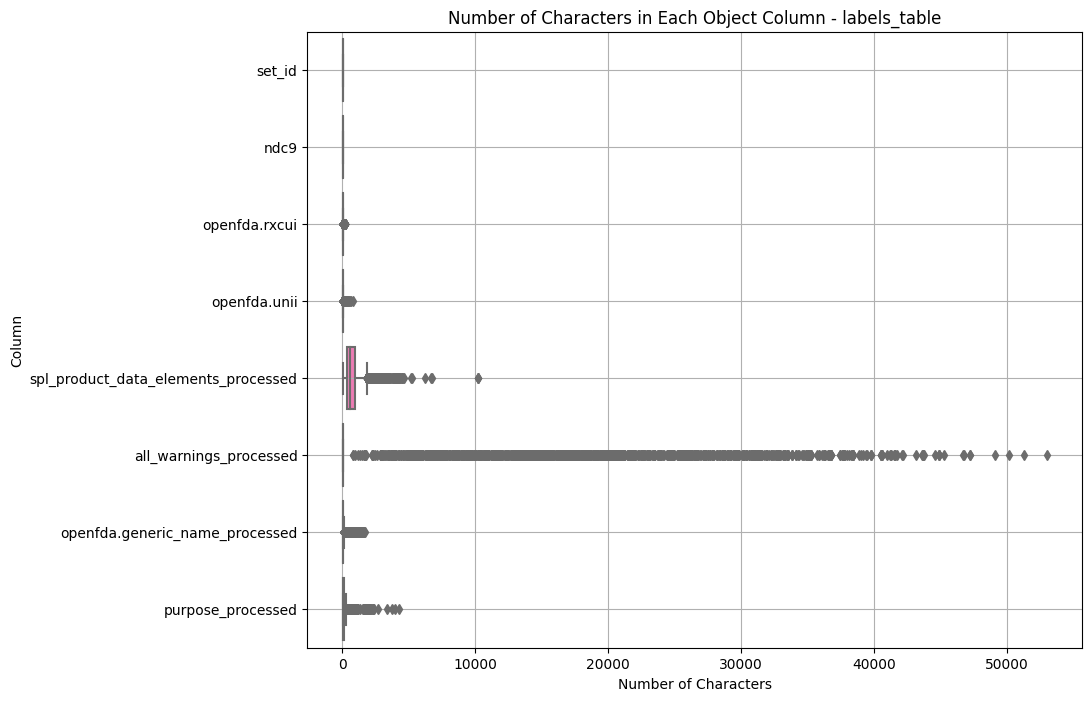


Descriptive Statistics on Character Length:
                                       count         mean          std   min  \
set_id                               12761.0    36.000000     0.000000  36.0   
ndc9                                 12761.0     5.424183     2.864562   3.0   
openfda.rxcui                        12761.0     8.848523    14.467254   3.0   
openfda.unii                         12761.0    13.018886    28.501191   3.0   
spl_product_data_elements_processed  12761.0   702.295823   565.426753   8.0   
all_warnings_processed               12761.0  2569.238853  7203.015481   3.0   
openfda.generic_name_processed       12761.0    38.640075   107.801018   4.0   
purpose_processed                    12761.0    85.980801   173.674967   4.0   

                                       25%    50%    75%      max  
set_id                                36.0   36.0   36.0     36.0  
ndc9                                   3.0    3.0    9.0      9.0  
openfda.rxcui                 

In [53]:
plot_character_length(labels_table, 'labels_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [54]:
labels_table_text_processed_outliers = examine_text_outliers(labels_table['all_warnings_processed'])
#print(labels_table_text_processed_outliers.iloc[2])

### Rename Columns

In [55]:
labels_table = labels_table.rename(columns = {'spl_product_data_elements_processed': 'ingredients',
                         'all_warnings_processed': 'warnings',
                         'openfda.generic_name_processed': 'drug_names',
                         'openfda.manufacturer_name_processed': 'manufacturer',
                         'purpose_processed': 'purpose'})

In [56]:
labels_table.head()

,set_id,label_id,year,ndc9,rxcui,unii,ingredients,warnings,drug_names,purpose
0,00146b91-008d-4b16-95b0-6077f98821be,1,2022,722880300,[198440],[362O9ITL9D],"[basic, care, acetaminophen, croscarmellose, s...",NaN,[acetaminophen],"[reliever, purpose, pain, fever, fever reducer..."
1,00179db3-5a76-4724-a848-28e71eb580a6,2,2022,710200016,[1046593],[F5UM2KM3W7],"[antibacterial, 2x, benzalkonium, chloride, wa...",NaN,"[benzalkonium, chloride, benzalkonium chloride]","[purpose, antibacterial, purpose antibacterial]"
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,3,2022,nan,NaN,NaN,"[truth, antibacterial, foaming, hand, wash, un...",NaN,<NA>,"[antimicrobial, purpose, purpose antimicrobial]"
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,4,2022,nan,NaN,NaN,"[lithium, bromatum, bromide, sucrose, lactose,...",NaN,<NA>,"[sleeplessness, us, relieve, symptom sleepless..."
4,001e5e85-ed03-4a0b-ae48-3a012882233a,5,2022,nan,NaN,NaN,"[iodoformum, iodoform, sucrose, lactose, white...",NaN,<NA>,"[cough, symptom cough, us, relieve, symptom, u..."


### Convert Lists to Text

In [57]:
columns_to_convert = ['rxcui', 'ingredients', 'drug_names', 'purpose', 'warnings', 'unii']


#FUNCTION HAS BEEN MOVED TO FUNCTIONS FILE
# def list_to_string(lst):
#     if isinstance(lst, list):
#         return ', '.join(lst)
#     else:
#         return lst  # Handle non-list values if any

# Apply function to convert lists to strings for each column
for col in columns_to_convert:
    labels_table[col] = labels_table[col].apply(list_to_string)


In [58]:
labels_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12761 entries, 0 to 12760
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   set_id       12761 non-null  object
 1   label_id     12761 non-null  int64 
 2   year         12761 non-null  int64 
 3   ndc9         12761 non-null  object
 4   rxcui        4303 non-null   object
 5   unii         5669 non-null   object
 6   ingredients  12761 non-null  object
 7   warnings     1823 non-null   object
 8   drug_names   5759 non-null   object
 9   purpose      7905 non-null   object
dtypes: int64(2), object(8)
memory usage: 997.1+ KB


#### Truncate Column Lengths

In [59]:
labels_table['warnings'] = labels_table['warnings'].apply(lambda x: x[:20000] if isinstance(x, str) else x)
labels_table['ingredients'] = labels_table['ingredients'].apply(lambda x: x[:5000] if isinstance(x, str) else x)
labels_table['set_id'] = labels_table['set_id'].apply(lambda x: x[:100] if isinstance(x, str) else x)
labels_table['unii'] = labels_table['unii'].apply(lambda x: x[:150] if isinstance(x, str) else x)
labels_table['purpose'] = labels_table['purpose'].apply(lambda x: x[:2200] if isinstance(x, str) else x)


In [110]:
## FOR TESTING SMALL SAMPLE ONLY ##
# Write the DataFrame to a CSV file
#labels_table.to_csv('DataLibrary/labels_table.csv', index=False)

In [ ]:
labels_table.to_csv('C://Users/halee/Downloads/labels_table2024.csv')

## PreProcess Events Table

In [8]:
events2023_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24685 entries, 0 to 24684
Data columns (total 40 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   safetyreportversion                       24685 non-null  object
 1   safetyreportid                            24685 non-null  object
 2   primarysourcecountry                      24547 non-null  object
 3   occurcountry                              22248 non-null  object
 4   transmissiondateformat                    24685 non-null  object
 5   transmissiondate                          24685 non-null  object
 6   reporttype                                24684 non-null  object
 7   serious                                   24685 non-null  object
 8   seriousnessdeath                          22802 non-null  object
 9   seriousnesslifethreatening                23192 non-null  object
 10  seriousnesshospitalization                2391

#### Select Columns

In [65]:
events_table = pd.DataFrame(events2024_df, 
                            columns = ["safetyreportid", #case report number
                                        "transmissiondate", # date the record was created
                                        "serious", # seriousness - 1 = result in death, lifethreatening,hospital,etc. 2 = not in the above
                                        "fulfillexpeditecriteria",  # 1 - Yes, 2 - No
                                        "primarysource.qualification",  # 1-MD, 2-Pharmacist, 3-Health Prof, 4-Lawyer, 5-Consumer/NonHealth
                                        "safetyreportversion",  # Indicates updated reports, with 1 being first, and increasing numbers as new 
                                        "companynumb",  # Company making report
                                        "seriousnessdeath", # 1 = death,
                                       "seriousnessdisabling",  # 1 = disabled
                                       "seriousnessother",  # 1 = other
                                       "seriousnesshospitalization",  # 1 = hospitalized
                                       "seriousnesslifethreatening",  # 1 = life threatening
                                       "duplicate",  # Duplicate status
                                       #"reportduplicate.duplicatesource",  # source of duplicate report
                                        #  "receivedateformat", #always YYYYMMDD
                                        #  "receivedate", #date report received by FDA
                                        "primarysource.reportercountry", # country of the reporter of this event
                                        "patient.patientonsetage", # age of patient when event occured
                                        "patient.patientonsetageunit",  # 801: Y, 802: M, 803: W, 804: D, 805: H 
                                        "patient.patientsex", # sex of patient. 0=unknown, 1=male, 2=female
                                       "patient.patientweight",  # Weight of patient in kg
                                        "patient.reaction", # Dictionary list - expanded as seperate table
                                        "patient.drug"]) # Dictionary list - expanded as separate table
                                        # "patient.patientagegroup", #1 = neonate, 2 = infant, 3=child, 4=adolescent, 5=adult, 6=elderly
                                        # "patient.patientweight", # weight in kg
                                        # "seriousnesscongentialanomali", # 1 if congenital anomaly (fetal abnormality),absent otherwise
                                        # "authoritynumb", #regulatory authority case #
                                        # "reportduplicate"
                                      

#### Fix Dtypes

In [66]:
events_table['transmissiondate'] = pd.to_datetime(events_table['transmissiondate'], format='%Y%m%d')
# Convert Date to Year
events_table['year'] = events_table['transmissiondate'].dt.year

#events_table['fulfillexpeditecriteria'] = events_table['fulfillexpeditecriteria'].astype(int)

#events_table['duplicate'].replace({np.nan: None}, inplace=True)
#events_table['duplicate'] = events_table['duplicate'].astype(pd.Int64Dtype())

#events_table['primarysource.qualification'].replace({np.nan: None}, inplace=True)
#events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(pd.Int64Dtype())

events_table['patient.patientonsetage'].replace({np.nan: None}, inplace=True)
events_table['patient.patientonsetage'] = events_table['patient.patientonsetage'].astype(pd.Int64Dtype())

events_table['patient.patientonsetageunit'].replace({np.nan: None}, inplace=True)
events_table['patient.patientonsetageunit'] = events_table['patient.patientonsetageunit'].astype(pd.Int64Dtype())

#events_table['patient.patientsex'].replace({np.nan: None}, inplace=True)
#events_table['patient.patientsex'] = events_table['patient.patientsex'].astype(pd.Int64Dtype())


### Standardize Age

In [67]:
events_table['patient.patientonsetage'] = events_table.apply(lambda row: convert_to_years(row['patient.patientonsetage'], row['patient.patientonsetageunit']), axis=1)
events_table.drop(columns=['patient.patientonsetageunit'], inplace=True)
events_table.head(5)

,safetyreportid,transmissiondate,serious,fulfillexpeditecriteria,primarysource.qualification,safetyreportversion,companynumb,seriousnessdeath,seriousnessdisabling,seriousnessother,seriousnesshospitalization,seriousnesslifethreatening,duplicate,primarysource.reportercountry,patient.patientonsetage,patient.patientsex,patient.patientweight,patient.reaction,patient.drug,year
0,10136162,2024-04-09,1,1,1,72,CA-ROCHE-1391410,2,2,1,2,2,1,CA,39.0,2,112,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2024
1,10142803,2024-04-09,1,1,1,16,CA-ROCHE-1390057,2,2,1,2,2,1,CA,57.0,1,74,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2024
2,10153990,2024-04-10,1,2,1,2,US-SHIRE-US201401849,2,2,1,2,2,NaN,US,44.0,2,61.22,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2024
3,10175722,2024-04-10,1,1,3,33,CA-ROCHE-1176621,2,2,1,2,2,NaN,CA,65.0,2,57,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2024
4,10209590,2024-04-10,1,1,3,19,CA-ROCHE-1409658,2,2,1,1,2,NaN,CA,42.0,2,50,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2024


### Assessing Weight - in KG

(array([7750., 4596., 2178., 1049.,  476.,  446.,  334.,  285.,  328.,
         341.,  265.,  253.,  240.,  219.,  222.,  179.,  216.,  172.,
         163.,  152.,  134.,  129.,   98.,  112.,  120.,  110.,   85.,
          88.,   78.,   67.]),
 array([   0.        ,   62.73333333,  125.46666667,  188.2       ,
         250.93333333,  313.66666667,  376.4       ,  439.13333333,
         501.86666667,  564.6       ,  627.33333333,  690.06666667,
         752.8       ,  815.53333333,  878.26666667,  941.        ,
        1003.73333333, 1066.46666667, 1129.2       , 1191.93333333,
        1254.66666667, 1317.4       , 1380.13333333, 1442.86666667,
        1505.6       , 1568.33333333, 1631.06666667, 1693.8       ,
        1756.53333333, 1819.26666667, 1882.        ]),
 <BarContainer object of 30 artists>)

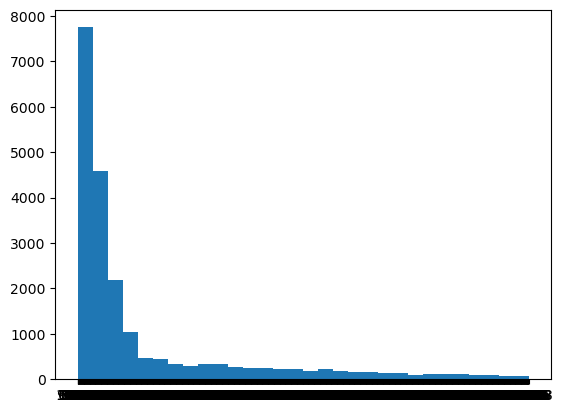

In [68]:
plt.hist(events_table['patient.patientweight'], bins = 30)

### Feature Engineering

In [69]:
events_table = add_sequential_index(events_table,'event_id')

#### Combining Levels of Seriousness into 3-Level Variable (death, serious, non-serious)

In [70]:
# Serious prior to mapping
events_table['serious'].value_counts()

serious
1    18865
2     2020
Name: count, dtype: int64

In [71]:
# Update seriousness categories into levels
events_table['seriousnessdeath']=events_table['seriousnessdeath'].replace({'2': '0'}).fillna('0').astype(str)
events_table['seriousnessdisabling']=events_table['seriousnessdisabling'].replace({'2': '0', '1': '2'}).fillna('0').astype(str)
events_table['seriousnesshospitalization']=events_table['seriousnesshospitalization'].replace({'2': '0', '1': '3'}).fillna('0').astype(str)
events_table['seriousnesslifethreatening']=events_table['seriousnesslifethreatening'].replace({'2': '0', '1': '4'}).fillna('0').astype(str)
events_table['seriousnessother']=events_table['seriousnessother'].replace({'2': '0', '1': '5'}).fillna('0').astype(str)
events_table['serious'] = events_table['serious'].replace({'2': '6', '1': '0'}).astype(str)

In [72]:
events_table['seriousnessdeath'].value_counts()

seriousnessdeath
0    18649
1     2236
Name: count, dtype: int64

In [73]:
events_table['seriousnessdisabling'].value_counts()

seriousnessdisabling
0    19869
2     1016
Name: count, dtype: int64

In [74]:
events_table['seriousnesshospitalization'].value_counts()

seriousnesshospitalization
0    10691
3    10194
Name: count, dtype: int64

In [75]:
events_table['seriousnesslifethreatening'].value_counts()

seriousnesslifethreatening
0    18526
4     2359
Name: count, dtype: int64

In [76]:
events_table['seriousnessother'].value_counts()

seriousnessother
5    12390
0     8495
Name: count, dtype: int64

In [77]:
events_table['serious'].value_counts()

serious
0    18865
6     2020
Name: count, dtype: int64

In [78]:
# String pattern denoting outcome
events_table['serious_outcome'] = events_table[['seriousnessdeath',
                                                'seriousnessdisabling',
                                                'seriousnesshospitalization',
                                                'seriousnesslifethreatening',
                                               'seriousnessother',
                                               'serious']].sum(axis=1)

In [79]:
# If string contains "1" - ultimately death, if any number 2-5 - serious, else non-serious
def process_serious_outcome(value):
    # NA already addressed in replace values above
    #if pd.isna(value):  # Check if the value is NaN
        #return 0  # Or whatever default value you prefer for NaNs
    str_value = str(value)  # Convert to string
    if str_value == "000006":
        return 0
    elif "1" in str_value:
        return 2
    else:
        return 1

events_table['serious_outcome'] = events_table['serious_outcome'].apply(process_serious_outcome)

In [80]:
events_table['serious_outcome'] = events_table['serious_outcome'].replace({'Death': 2, 'Serious': 1, 'NonSerious': 0})

In [81]:
events_table['serious_outcome'].value_counts()

serious_outcome
1    16629
2     2236
0     2020
Name: count, dtype: int64

In [82]:
events_table['serious_outcome'].value_counts(normalize = True)

serious_outcome
1    0.796217
2    0.107062
0    0.096720
Name: proportion, dtype: float64

### Check for Report Duplicates - openFDA return only most recent report

In [28]:
# Check for safety report # duplicates
duplicates = events_table.duplicated(subset=['safetyreportid']).sum()

print("Duplicates: ", duplicates) 

Duplicates:  0


In [27]:
events_table[['safetyreportid', 'safetyreportversion', 'duplicate']].head(5)

,safetyreportid,safetyreportversion,duplicate
0,10035616,7,1
1,10064018,78,NaN
2,10274879,83,NaN
3,10344397,3,1
4,10368721,6,NaN


### Examine and Handle Nulls

In [28]:
events_nan = nan_info(events_table)
events_nan

,column_name,null_count,null_proportion
0,event_id,0,0.000000
1,safetyreportid,0,0.000000
2,transmissiondate,0,0.000000
3,serious,0,0.000000
4,fulfillexpeditecriteria,0,0.000000
5,primarysource.qualification,0,0.000000
6,safetyreportversion,0,0.000000
7,companynumb,5668,22.961313
8,seriousnessdeath,0,0.000000
9,seriousnessdisabling,0,0.000000


In [83]:
sex_value_counts = events_table['patient.patientsex'].value_counts()
print(sex_value_counts)

## ONLY KNOWN/REPORTED SEX RETRIEVED IN API REQUEST ##

#For sex, 0=unknown, 1=male, 2=female. fill missing values with 0.
#events_table['patient.patientsex'] = events_table['patient.patientsex'].fillna(0)

patient.patientsex
2    11503
1     9382
Name: count, dtype: int64


### Filter Events for Quality Data
* Remove events that have consumer and lawyer reports (already done in API request)
* Verify that API called only most recent version of reports

In [32]:
## THIS FILTER APPLIED IN INITIAL API REQUEST ##

# Drop NaN values in 'primarysource.qualification'
#events_table.dropna(subset=['primarysource.qualification'], inplace=True)

# Convert 'primarysource.qualification' to integer
#events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(int)

# Filter out values 4 and 5
#events_table = events_table[~events_table['primarysource.qualification'].isin([4, 5])]

#events_table.shape

In [33]:
# Verified that version control exists in API request
events_table[['safetyreportid', 'safetyreportversion']].head(10)

,safetyreportid,safetyreportversion
0,10023591,2
1,10023599,2
2,10023600,2
3,10023601,2
4,10023602,2
5,10023606,2
6,10051458,3
7,10085951,5
8,10143932,4
9,10149169,2


In [30]:
events_table.dtypes

event_id                                  int64
safetyreportid                           object
transmissiondate                 datetime64[ns]
serious                                  object
fulfillexpeditecriteria                  object
primarysource.qualification              object
safetyreportversion                      object
companynumb                              object
seriousnessdeath                         object
seriousnessdisabling                     object
seriousnessother                         object
seriousnesshospitalization               object
seriousnesslifethreatening               object
duplicate                                object
primarysource.reportercountry            object
patient.patientonsetage                 float64
patient.patientsex                       object
patient.patientweight                    object
patient.reaction                         object
patient.drug                             object
year                                    

### Rename Columns

In [84]:
# Rename some columns
events_table = events_table.rename(columns={
    'primarysource.reportercountry': 'country',
    'patient.patientsex': 'sex',
    'patient.patientonsetage': 'age',
    'patient.patientweight': 'weight',
    'patient.reaction': 'reaction',
    'patient.drug': 'drug',
    'fulfillexpeditecriteria': 'expedited',
    'primarysource.qualification': 'report_source',
    'companynumb': 'company'
})

In [85]:
#pd.reset_option('display.max_colwidth')
events_table.head()

,event_id,safetyreportid,transmissiondate,serious,expedited,report_source,safetyreportversion,company,seriousnessdeath,seriousnessdisabling,...,seriousnesslifethreatening,duplicate,country,age,sex,weight,reaction,drug,year,serious_outcome
0,1,10136162,2024-04-09,0,1,1,72,CA-ROCHE-1391410,0,0,...,0,1,CA,39.0,2,112,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2024,1
1,2,10142803,2024-04-09,0,1,1,16,CA-ROCHE-1390057,0,0,...,0,1,CA,57.0,1,74,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2024,1
2,3,10153990,2024-04-10,0,2,1,2,US-SHIRE-US201401849,0,0,...,0,NaN,US,44.0,2,61.22,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2024,1
3,4,10175722,2024-04-10,0,1,3,33,CA-ROCHE-1176621,0,0,...,0,NaN,CA,65.0,2,57,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2024,1
4,5,10209590,2024-04-10,0,1,3,19,CA-ROCHE-1409658,0,0,...,0,NaN,CA,42.0,2,50,"[{'reactionmeddraversionpt': '26.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2024,1


In [32]:
events_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24685 entries, 0 to 24684
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   event_id                    24685 non-null  int64         
 1   safetyreportid              24685 non-null  object        
 2   transmissiondate            24685 non-null  datetime64[ns]
 3   serious                     24685 non-null  object        
 4   expedited                   24685 non-null  object        
 5   report_source               24685 non-null  object        
 6   safetyreportversion         24685 non-null  object        
 7   company                     19017 non-null  object        
 8   seriousnessdeath            24685 non-null  object        
 9   seriousnessdisabling        24685 non-null  object        
 10  seriousnessother            24685 non-null  object        
 11  seriousnesshospitalization  24685 non-null  object    

### Make new table for PatientDrugs - nested dataframe

#### Without MultiProcessing

In [86]:
start_time = time.time()

expanded_patient_drugs = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['drug']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_drugs.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_drugs_df = pd.concat(expanded_patient_drugs, ignore_index=True)
patient_drugs_df = patient_drugs_df[['event_id'] + [col for col in patient_drugs_df.columns if col != 'event_id']]


end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

4683.974413394928


In [87]:
patient_drugs_df.shape

(253190, 44)

In [89]:
patient_drugs_df.to_csv('C://Users/halee/Downloads/drugs_raw.csv')

In [88]:
drugs_back_up = patient_drugs_df
drugs_back_up.head()

,event_id,drugcharacterization,medicinalproduct,drugbatchnumb,drugauthorizationnumb,drugstructuredosagenumb,drugstructuredosageunit,drugseparatedosagenumb,drugintervaldosageunitnumb,drugintervaldosagedefinition,...,drugdosagetext,openfda.pharm_class_cs,drugadditional,drugenddateformat,drugenddate,drugtreatmentduration,drugtreatmentdurationunit,drugcumulativedosagenumb,drugcumulativedosageunit,drugrecurreadministration
0,1,1,XOLAIR,"SHP19,ASKED BUT UNKNOWN,SERP4,ASKED",103976,300,003,1,4,803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,XOLAIR,"SHP19,ASKED BUT UNKNOWN,SERP4,ASKED",103976,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,XOLAIR,"SHP19,ASKED BUT UNKNOWN,SERP4,ASKED",103976,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,XOLAIR,"SHP19,ASKED BUT UNKNOWN,SERP4,ASKED",103976,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,XOLAIR,"SHP19,ASKED BUT UNKNOWN,SERP4,ASKED",103976,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
nan_info(patient_drugs_df)

,column_name,null_count,null_proportion
0,event_id,0,0.000000
1,drugcharacterization,0,0.000000
2,medicinalproduct,0,0.000000
3,drugbatchnumb,209105,82.588175
4,drugauthorizationnumb,207952,82.132786
5,drugstructuredosagenumb,125800,49.686007
6,drugstructuredosageunit,125800,49.686007
7,drugseparatedosagenumb,162909,64.342589
8,drugintervaldosageunitnumb,174263,68.826968
9,drugintervaldosagedefinition,174263,68.826968


In [37]:
#events_table['drug'].iloc[1]
#events_table_subset = events_table.iloc[:3000]
#events_table_subset.head(7)

In [36]:
#import pandas as pd
#import json
#import re
#import logging

# Set up basic configuration for logging
#logging.basicConfig(level=logging.ERROR)

#def clean_json_string(json_str):
#    if json_str is None:
#        return None
#    # Replace single quotes with double quotes
#    json_str = json_str.replace("'", '"')
#    
#    # Remove trailing commas before closing brackets
#    json_str = re.sub(r',(\s*[\]}])', r'\1', json_str)
#    
#    # Remove extra commas within lists
#    json_str = re.sub(r',(\s*[\]])', r'\1', json_str)
#    
#    # Ensure that escaped quotes are correctly formatted
#    json_str = re.sub(r'\\\"', '"', json_str)
#    
#    return json_str

#def safely_parse_json(json_str):
#    if json_str is None:
#        return None
#    try:
#        json_str = clean_json_string(json_str)
#        return json.loads(json_str)
#    except json.JSONDecodeError as e:
#        logging.error(f"Error parsing JSON: {e}")
#        snippet = json_str[:1000]
#        logging.error(f"Problematic JSON snippet: {snippet}...")
#        return None

#def flatten_dict(d, parent_key='', sep='_'):
#    items = []
#    for k, v in d.items():
#        new_key = f"{parent_key}{k}" if parent_key == '' else f"{parent_key}{sep}{k}"
#        if isinstance(v, dict):
#            items.extend(flatten_dict(v, new_key, sep=sep).items())
#        elif isinstance(v, list):
#            for i, item in enumerate(v):
#                if isinstance(item, dict):
#                    items.extend(flatten_dict(item, f"{new_key}{sep}{i}", sep=sep).items())
#                else:
#                    items.append((f"{new_key}{sep}{i}", item))
#        else:
#            items.append((new_key, v))
#    return dict(items)

#def extract_and_flatten_drug(row):
#    event_id = row['event_id']
#    drug_entries = row['drug']
#    
#    if not isinstance(drug_entries, list):
#        return []
    
#    expanded_entries = []
#    for drug_entry in drug_entries:
#        if isinstance(drug_entry, dict):
#            flattened_entry = flatten_dict(drug_entry)
#            flattened_entry['event_id'] = event_id
#            expanded_entries.append(flattened_entry)
    
#    return expanded_entries

# Apply the JSON cleaning and parsing to the 'drug' column
#events_table_subset['drug'] = events_table_subset['drug'].apply(
#    lambda x: safely_parse_json(x) if isinstance(x, str) else x
#)

# Extract and flatten all columns from the 'drug' dictionary, keeping 'event_id'
#expanded_data = []
#for _, row in events_table_subset.iterrows():
#    entries = extract_and_flatten_drug(row)
#    expanded_data.extend(entries)

# Convert the list of expanded entries to a DataFrame
#patient_drugs_df = pd.DataFrame(expanded_data)

# Reorder columns to ensure 'event_id' is the first column
#if not patient_drugs_df.empty and 'event_id' in patient_drugs_df.columns:
    # Reorder columns with 'event_id' as the first column
#    columns = ['event_id'] + [col for col in patient_drugs_df.columns if col != 'event_id']
#    patient_drugs_df = patient_drugs_df[columns]

# Display the DataFrame
#print(patient_drugs_df.head())


In [33]:
#pd.set_option('display.max_columns', None)
#patient_drugs_df['product_ndc']

#### With MultiProcessing

In [ ]:
# from pandas import json_normalize

# start_time = time.time()
# expanded_patient_drugs = []
# def process_row(row):
#     expanded_patient_drugs = []
#     event_id = row['event_id']
    
#     # Iterate through each drug entry in 'drug' list
#     for drug_entry in row['drug']:
#         flattened_entry = json_normalize(drug_entry)
#         flattened_entry['event_id'] = event_id
#         expanded_patient_drugs.append(flattened_entry)
#     # 
#     return pd.concat(expanded_patient_drugs, ignore_index=True)

# if __name__ == '__main__':
#     num_cores = mp.cpu_count()  # Number of CPU cores
#     with mp.Pool(num_cores) as pool:
#         patient_drugs_list = pool.map(process_row, events_table_subset.to_dict('records'))

#     # Concatenate all entries into a new DataFrame
#     patient_drugs_df = pd.concat(patient_drugs_list, ignore_index=True)
#     patient_drugs_df = patient_drugs_df[['event_id'] + [col for col in patient_drugs_df.columns if col != 'event_id']]

# end_time = time.time()
# execution_time = end_time - start_time
# print(execution_time)

### Make new table for PatientReactions

#### Without MultiProcessing

In [91]:
start_time = time.time()

expanded_patient_reaction = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['reaction']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_reaction.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_reactions_df = pd.concat(expanded_patient_reaction, ignore_index=True)
patient_reactions_df = patient_reactions_df[['event_id'] + [col for col in patient_reactions_df.columns if col != 'event_id']]

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

135.44738149642944


In [92]:
patient_reactions_df.head(10)

,event_id,reactionmeddraversionpt,reactionmeddrapt,reactionoutcome
0,1,26.1,Blood pressure decreased,6
1,1,26.1,Disorientation,6
2,1,26.1,Speech disorder,6
3,1,26.1,Flushing,6
4,1,26.1,Nausea,6
5,1,26.1,Asthma,3
6,1,26.1,Forced expiratory volume decreased,3
7,1,26.1,Wheezing,6
8,1,26.1,Dizziness,6
9,1,26.1,Blood pressure increased,3


In [39]:
#import pandas as pd
#import json
#import re
#import logging

# Set up basic configuration for logging
#logging.basicConfig(level=logging.ERROR)

#def clean_json_string(json_str):
#    if json_str is None:
#        return None
#    # Replace single quotes with double quotes
#    json_str = json_str.replace("'", '"')
    
    # Remove trailing commas before closing brackets
#    json_str = re.sub(r',(\s*[\]}])', r'\1', json_str)
    
    # Remove extra commas within lists
#    json_str = re.sub(r',(\s*[\]])', r'\1', json_str)
    
    # Ensure that escaped quotes are correctly formatted
#    json_str = re.sub(r'\\\"', '"', json_str)
    
#    return json_str

#def safely_parse_json(json_str):
#    if json_str is None:
#        return None
#    try:
#        json_str = clean_json_string(json_str)
#        return json.loads(json_str)
#    except json.JSONDecodeError as e:
#        logging.error(f"Error parsing JSON: {e}")
#        snippet = json_str[:1000]
#        logging.error(f"Problematic JSON snippet: {snippet}...")
#        return None

#def flatten_dict(d, parent_key='', sep='_'):
#    items = []
#    for k, v in d.items():
#        new_key = f"{parent_key}{k}" if parent_key == '' else f"{parent_key}{sep}{k}"
#        if isinstance(v, dict):
#            items.extend(flatten_dict(v, new_key, sep=sep).items())
#        elif isinstance(v, list):
#            for i, item in enumerate(v):
#                if isinstance(item, dict):
#                    items.extend(flatten_dict(item, f"{new_key}{sep}{i}", sep=sep).items())
#                else:
#                    items.append((f"{new_key}{sep}{i}", item))
#        else:
#            items.append((new_key, v))
#    return dict(items)

#def extract_and_flatten_reaction(row):
#    event_id = row['event_id']
#    reaction_entries = row['reaction']
    
#    if not isinstance(reaction_entries, list):
#        return []
    
#    expanded_entries = []
#    for reaction_entry in reaction_entries:
#        if isinstance(reaction_entry, dict):
#            flattened_entry = flatten_dict(reaction_entry)
#            flattened_entry['event_id'] = event_id
#            expanded_entries.append(flattened_entry)
    
#    return expanded_entries

# Apply the JSON cleaning and parsing to the 'reaction' column
#events_table_subset['reaction'] = events_table_subset['reaction'].apply(
#    lambda x: safely_parse_json(x) if isinstance(x, str) else x
#)

# Extract and flatten all columns from the 'reaction' dictionary, keeping 'event_id'
#expanded_data = []
#for _, row in events_table_subset.iterrows():
#    entries = extract_and_flatten_reaction(row)
#    expanded_data.extend(entries)

# Convert the list of expanded entries to a DataFrame
#patient_reactions_df = pd.DataFrame(expanded_data)

# Reorder columns to ensure 'event_id' is the first column
#if not patient_reactions_df.empty and 'event_id' in patient_reactions_df.columns:
    # Reorder columns with 'event_id' as the first column
#    columns = ['event_id'] + [col for col in patient_reactions_df.columns if col != 'event_id']
#    patient_reactions_df = patient_reactions_df[columns]

# Display the DataFrame
#print(patient_reactions_df.head())


In [40]:
patient_reactions_df.shape

(112583, 4)

In [93]:
patient_reactions_df.to_csv('C://Users/halee/Downloads/reactions_raw.csv')

#### With MultiProcessing

In [ ]:
# start_time = time.time()

# def process_row(row):
#     expanded_patient_reaction = []
#     event_id = row['event_id']
    
#     # Iterate through each reaction entry in 'reaction' list
#     for reaction_entry in row['reaction']:
#         flattened_entry = json_normalize(reaction_entry)
#         flattened_entry['event_id'] = event_id
#         expanded_patient_reaction.append(flattened_entry)
    
#     return pd.concat(expanded_patient_reaction, ignore_index=True)

# if __name__ == '__main__':
#     num_cores = mp.cpu_count()  # Number of CPU cores

#     with mp.Pool(num_cores) as pool:
#         # Use pool.map to process each row in parallel
#         patient_reactions_list = pool.map(process_row, events_table.to_dict('records'))

#     # Concatenate all entries into a new DataFrame
#     patient_reactions_df = pd.concat(patient_reactions_list, ignore_index=True)
#     patient_reactions_df = patient_reactions_df[['event_id'] + [col for col in patient_reactions_df.columns if col != 'event_id']]
    
# end_time = time.time()
# execution_time = end_time - start_time
# print(execution_time)

### Remove Drug and Reaction Columns as they are in new tables

In [94]:
events_table.drop(['drug', 'reaction'], axis=1, inplace=True)

### Assess Text Field Lengths

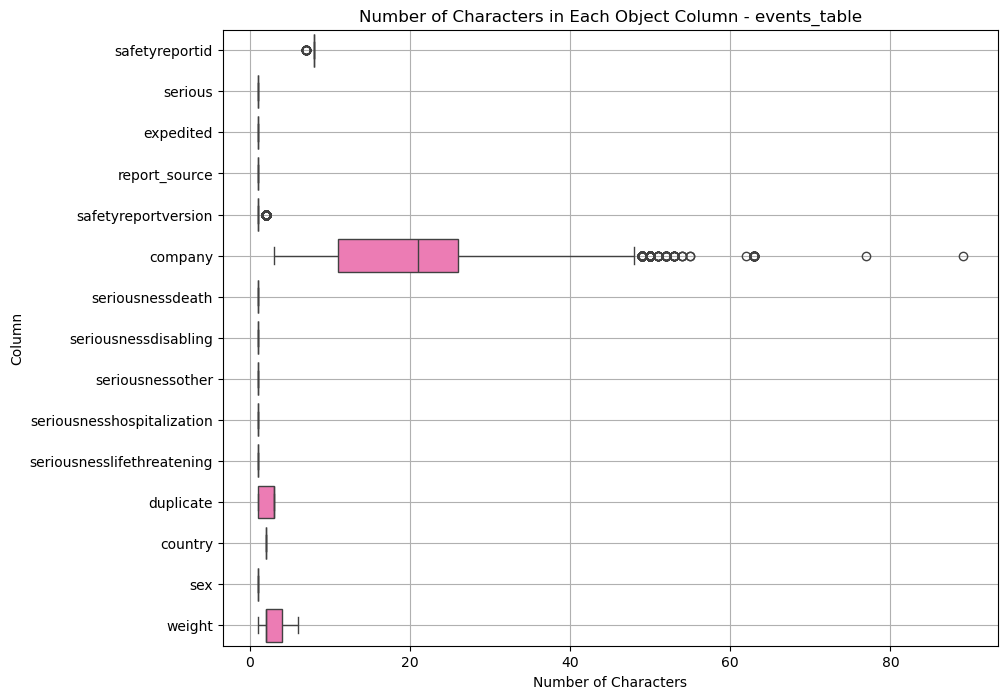


Descriptive Statistics on Character Length:
                              count       mean        std  min   25%   50%  \
safetyreportid              24685.0   7.999028   0.031166  7.0   8.0   8.0   
serious                     24685.0   1.000000   0.000000  1.0   1.0   1.0   
expedited                   24685.0   1.000000   0.000000  1.0   1.0   1.0   
report_source               24685.0   1.000000   0.000000  1.0   1.0   1.0   
safetyreportversion         24685.0   1.037310   0.189524  1.0   1.0   1.0   
company                     24685.0  20.113753  12.159777  3.0  11.0  21.0   
seriousnessdeath            24685.0   1.000000   0.000000  1.0   1.0   1.0   
seriousnessdisabling        24685.0   1.000000   0.000000  1.0   1.0   1.0   
seriousnessother            24685.0   1.000000   0.000000  1.0   1.0   1.0   
seriousnesshospitalization  24685.0   1.000000   0.000000  1.0   1.0   1.0   
seriousnesslifethreatening  24685.0   1.000000   0.000000  1.0   1.0   1.0   
duplicate          

In [50]:
plot_character_length(events_table, 'events_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [51]:
events_table_text_processed_outliers = examine_text_outliers(events_table['company'])
print(events_table_text_processed_outliers.iloc[2])

ES-BOEHRINGER INGELHEIM GMBH, GERMANY-2016-BI-21455II


#### Custom Text Processing of Company Information - Retain Name Only

In [95]:
# Creat list of country abbreviations and extra abbreviations to remove from text data
country_codes = events_table['country'].dropna().unique().tolist()
country_codes = [i.lower() for i in country_codes]
country_codes = ['cn' if country == 'canada' else country for country in country_codes]
country_codes = country_codes+["usa", "isr", "ger", "tus", "dklu", "bp", "sp",
                                  "nj", "aus", "deuct", "ve", "pomal", "gbr",
                                  "jacan", "fra", "deu", 'deuct', 'ita',
                              'gw', 'jet', 'aur', 'aut', 'ml',
                              'eut', 'ent', 'sp', 'chn',
                              'jpn', 'kor', 'can', 'europe',
                              'bw', 'rr', 'eu', 'bl', 'deusp',
                              'uki', 'japan', 'teu', 'ind']

extra_abv = ['nldsp', 'usasp', 'company', 'bax', 'spo',
                'ccaza', 'cinry', 'and', 'cansp', 'oxyc',
            'scpr', 'gbrct', 'gbrsp', 'tjp', 'unk',
            'frasp', 'brasp', 'sol', 'cbst','pmco',
            'jpnct', 'frua', 'espct', 'pre',
            'dsu', 'gmbh', 'dse', 'belsp', 'crisp',
            'kdl', 'irlsp', 'mpi', 'avee', 'usani', 
            'sun', 'belct', 'itasp', 'hkgsp', 'argsp',
            'aegr']

country_codes_df = pd.DataFrame({'codes': country_codes})

# save list of country codes
country_codes_df.to_csv('DataLibrary/country_codes.csv', index=False)

##### No Multiprocessing

In [97]:
start_time = time.time() 

events_table['company_name'] = events_table['company'].astype(str).apply(process_company_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

39.433526039123535


##### With Multiprocessing

In [ ]:
# Create a pool with the same number of workers as CPU cores
#start_time = time.time() 
#if __name__ == '__main__':
#    with mp.Pool(num_cores) as pool:
#        company_name = pool.map(process_company_text, events_table['company'])
#        events_table['company_name'] = company_name
#    # Apply the process_company_row function to each element in the 'company' column in parallel
#end_time = time.time()
#execution_time = end_time - start_time
#print(execution_time)

In [98]:
events_table[['company', 'company_name', 'country']].head(20) 

,company,company_name,country
0,CA-ROCHE-1391410,[roche],CA
1,CA-ROCHE-1390057,[roche],CA
2,US-SHIRE-US201401849,[shire],US
3,CA-ROCHE-1176621,[roche],CA
4,CA-ROCHE-1409658,[roche],CA
5,JP-PFIZER INC-2014165904,"[pfizer, inc]",JP
6,FR-SA-2014SA085306,<NA>,FR
7,CA-ROCHE-1098542,[roche],CA
8,FR-ROCHE-1457215,[roche],FR
9,PHEH2014US010494,[pubhosp],US


In [ ]:
# Set display option to show the full list without truncation
#pd.set_option('display.max_rows', None)
#events_table['company_name'].value_counts()
# Reset display option to default
#pd.reset_option('display.max_rows')

#### Text Processing of Country Name

In [99]:
# Replace category missing label with NA and Canada
events_table['country'] = events_table['country'].replace({"COUNTRY NOT SPECIFIED": pd.NA, "CANADA": 'CN'})

# Lower case country code text
events_table['country'] = events_table['country'].apply(lambda x: x.lower() if pd.notna(x) else x)

In [100]:
# Drop Cryptic company information
events_table.drop(['company'], axis = 1, inplace = True)

In [101]:
events_table[['company_name', 'country']].head(10) 

,company_name,country
0,[roche],ca
1,[roche],ca
2,[shire],us
3,[roche],ca
4,[roche],ca
5,"[pfizer, inc]",jp
6,<NA>,fr
7,[roche],ca
8,[roche],fr
9,[pubhosp],us


### Reeaxmine Field Lengths

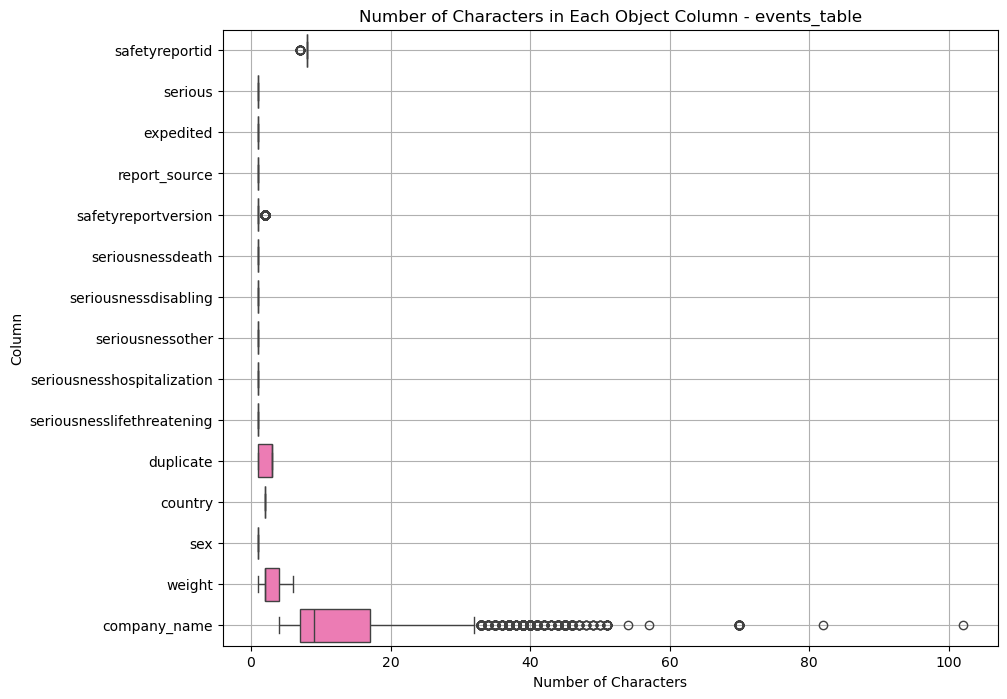


Descriptive Statistics on Character Length:
                              count       mean       std  min  25%  50%   75%  \
safetyreportid              24685.0   7.999028  0.031166  7.0  8.0  8.0   8.0   
serious                     24685.0   1.000000  0.000000  1.0  1.0  1.0   1.0   
expedited                   24685.0   1.000000  0.000000  1.0  1.0  1.0   1.0   
report_source               24685.0   1.000000  0.000000  1.0  1.0  1.0   1.0   
safetyreportversion         24685.0   1.037310  0.189524  1.0  1.0  1.0   1.0   
seriousnessdeath            24685.0   1.000000  0.000000  1.0  1.0  1.0   1.0   
seriousnessdisabling        24685.0   1.000000  0.000000  1.0  1.0  1.0   1.0   
seriousnessother            24685.0   1.000000  0.000000  1.0  1.0  1.0   1.0   
seriousnesshospitalization  24685.0   1.000000  0.000000  1.0  1.0  1.0   1.0   
seriousnesslifethreatening  24685.0   1.000000  0.000000  1.0  1.0  1.0   1.0   
duplicate                   24685.0   2.020296  0.999814  1.0  1

In [58]:
plot_character_length(events_table, 'events_table')

In [59]:
examine_text_outliers(events_table['company_name']).iloc[0:10]

34                [bristol, myers, squibb, bms]
41     [boehringer, ingelheim, germany, bi, ff]
53     [boehringer, ingelheim, germany, bi, ii]
72                [bristol, myers, squibb, bms]
79                       [pfizer, inc, hq, jun]
93             [viiv, healthcare, limited, gsk]
99                [bristol, myers, squibb, bms]
144               [bristol, myers, squibb, bms]
153       [ipsen, group, research, development]
156               [bristol, myers, squibb, bms]
Name: company_name, dtype: object

In [ ]:
events_table.dtypes

#### Choose Final List of Features

In [102]:
events_table = events_table[['event_id',
                            'year',
                            'expedited',
                            'report_source',
                            'country',
                            'age',
                            'sex',
                            'weight',
                            'serious_outcome',
                            'company_name']]

### Convert Lists to Text

In [61]:
# Function to convert list to concatenated string
def list_to_string(lst):
    if isinstance(lst, list):
        return ', '.join(lst)
    else:
        return lst  # Handle non-list values if any

In [63]:
test_list = ['bristol', 'myers', 'squibb', 'bms']
test_output = list_to_string(test_list)
test_output

'bristol, myers, squibb, bms'

In [ ]:
#events_table['company_name'] = events_table['company_name'].apply(list_to_string)

### Save Data to Library

In [64]:
events_table.head()

,event_id,year,expedited,report_source,country,age,sex,weight,serious_outcome,company_name
0,1,2024,1,1,jp,84.0,2,50,2,[nbi]
1,2,2024,1,3,ca,71.0,2,77,1,[roche]
2,3,2024,1,3,ca,46.0,1,100,1,[roche]
3,4,2024,1,2,nl,81.0,2,56,1,[amgen]
4,5,2024,1,1,it,68.0,1,77,2,[pubhosp]


In [104]:
events_table['serious_outcome'].value_counts()

serious_outcome
1    16629
2     2236
0     2020
Name: count, dtype: int64

In [66]:
# Write the DataFrame to a CSV file
#events_table.to_csv('DataLibrary/events_table2024.csv', index=False)

In [103]:
# Save local as back up
events_table.to_csv('C://Users/halee/Downloads/events_table2024.csv', index=False)

## PreProcess Patient Drugs Table

In [105]:
patient_drugs_df.head()
patient_drugs_df.columns

Index(['event_id', 'drugcharacterization', 'medicinalproduct', 'drugbatchnumb',
       'drugauthorizationnumb', 'drugstructuredosagenumb',
       'drugstructuredosageunit', 'drugseparatedosagenumb',
       'drugintervaldosageunitnumb', 'drugintervaldosagedefinition',
       'drugdosageform', 'drugadministrationroute', 'drugindication',
       'drugstartdateformat', 'drugstartdate', 'actiondrug',
       'activesubstance.activesubstancename', 'openfda.application_number',
       'openfda.brand_name', 'openfda.generic_name',
       'openfda.manufacturer_name', 'openfda.product_ndc',
       'openfda.product_type', 'openfda.route', 'openfda.substance_name',
       'openfda.rxcui', 'openfda.spl_id', 'openfda.spl_set_id',
       'openfda.package_ndc', 'openfda.nui', 'openfda.pharm_class_epc',
       'openfda.pharm_class_pe', 'openfda.pharm_class_moa', 'openfda.unii',
       'drugdosagetext', 'openfda.pharm_class_cs', 'drugadditional',
       'drugenddateformat', 'drugenddate', 'drugtreatmentd

#### Select Columns

In [116]:
patient_drugs_table = pd.DataFrame(patient_drugs_df, 
                               columns = [
                                'event_id',  # Identifier for the event
                                'drugcharacterization',  # Level of detail for the drug in the event report
                                'medicinalproduct',  # Name of the drug
                                'activesubstance.activesubstancename',  # Active ingredient
                                # 'drugauthorizationnumb',  # Marketing authorization number of the drug
                                # 'drugadministrationroute',  # Route of administration for the drug
                                #'drugindication',  # Indication for use of the drug
                                # 'drugbatchnumb',  # Batch number for the drug
                                # 'drugstructuredosagenumb',  # Structured dosage number of the drug
                                # 'drugstructuredosageunit',  # Unit of structured dosage for the drug
                                # 'drugdosagetext',  # Textual description of the dosage for the drug
                                # 'drugstartdateformat',  # Date format for the start date of drug administration
                                # 'drugstartdate',  # Start date of drug administration
                                #'drugrecurreadministration',  # Indicator for recurring drug administration
                                # 'drugadditional',  # Additional details about the drug
                                # 'openfda.application_number',  # FDA application number for the drug
                                # 'openfda.brand_name',  # Brand name for the drug
                                'openfda.generic_name',  # Generic name for the drug
                                'openfda.manufacturer_name',  # Manufacturer name for the drug
                                'openfda.product_ndc',  # NDC (National Drug Code) number for the drug product
                                #'openfda.product_type',  # Type of drug product (e.g., HUMAN PRESCRIPTION DRUG)
                                # 'openfda.route',  # Route of administration for the drug
                                # 'openfda.substance_name',  # Substance name associated with the drug
                                'openfda.rxcui',  # RxNorm Concept Unique Identifier (RxCUI) for the drug
                                # 'openfda.spl_id',  # Structured Product Labeling (SPL) ID for the drug
                                'openfda.spl_set_id',  # SPL Set ID for the drug
                                #'openfda.package_ndc',  # NDC (National Drug Code) number for the drug package
                                # 'openfda.nui',  # NUI (National Uniform Identifier) for the drug
                                # 'openfda.pharm_class_moa',  # Pharmacological class (Mechanism of Action) for the drug
                                # 'openfda.pharm_class_cs',  # Chemical structure class for the drug
                                # 'openfda.pharm_class_epc',  # Pharmacological class (EPC) for the drug
                                'openfda.unii',  # Unique Ingredient Identifier (UNII) for the drug substance
                                # 'actiondrug',  # Action taken with the drug
                                # 'drugdosageform',  # Dosage form of the drug
                                # 'openfda.pharm_class_pe',  # Pharmacological class (Physiologic Effect) for the drug
                                # 'activesubstance.activesubstancename',  # Name of the active substance in the drug
                                # 'drugenddateformat',  # Date format for the end date of drug administration
                                # 'drugenddate',  # End date of drug administration
                                #'drugseparatedosagenumb',  # Separated dosage number for the drug
                                # 'drugintervaldosageunitnumb',  # Interval dosage unit number for the drug
                                # 'drugintervaldosagedefinition',  # Definition of interval dosage for the drug
                                # 'drugcumulativedosagenumb',  # Cumulative dosage number for the drug
                                # 'drugcumulativedosageunit'  # Unit of cumulative dosage for the drug
                            ])


In [117]:
patient_drugs_table['medicinalproduct'].value_counts()

medicinalproduct
PREDNISONE                  3486
ACETAMINOPHEN               3463
METHOTREXATE                3458
ACTEMRA                     3111
DEXAMETHASONE               2944
                            ... 
DERMOSOL G                     1
AFRIN NASAL DECONGESTANT       1
METROGEL                       1
COSOPT PF                      1
ALESSE 28                      1
Name: count, Length: 8701, dtype: int64

#### Fix Dtypes

In [118]:
patient_drugs_table['drugcharacterization'] = patient_drugs_table['drugcharacterization'].astype(int)

#### Filter for Quality Data

In [119]:
patient_drugs_table['drugcharacterization'].value_counts()

drugcharacterization
1    146567
2    105642
3       981
Name: count, dtype: int64

In [120]:
# Keep only primary drug suspects
patient_drugs_table = patient_drugs_table.loc[patient_drugs_table['drugcharacterization'] == 1]

In [121]:
patient_drugs_table['drugcharacterization'].value_counts()

drugcharacterization
1    146567
Name: count, dtype: int64

#### Examining Variables of Interest
* Drugcharacterization: 1-suspect(drug primary cause), 2-concomitant(drug taken with primary cause), 3-interation(drug interact with primary cause)
* Medicinalproduct: generic or brand name
* Drugindication: official drug purpose
* openfda.rxcui : Rx cui code
* openfda.unii : unique ingredient identifier

### Examine Nulls

In [122]:
patient_drugs_table_nan_info = nan_info(patient_drugs_table)
patient_drugs_table_nan_info

,column_name,null_count,null_proportion
0,event_id,0,0.000000
1,drugcharacterization,0,0.000000
2,medicinalproduct,0,0.000000
3,activesubstance.activesubstancename,0,0.000000
4,openfda.generic_name,21207,14.469151
5,openfda.manufacturer_name,21207,14.469151
6,openfda.product_ndc,21207,14.469151
7,openfda.rxcui,23230,15.849407
8,openfda.spl_set_id,21207,14.469151
9,openfda.unii,22988,15.684295


### Filter for First NDC/RXCUI/SET ID if contains list

In [123]:
patient_drugs_table.head()

,event_id,drugcharacterization,medicinalproduct,activesubstance.activesubstancename,openfda.generic_name,openfda.manufacturer_name,openfda.product_ndc,openfda.rxcui,openfda.spl_set_id,openfda.unii
0,1,1,XOLAIR,OMALIZUMAB,[OMALIZUMAB],"[Genentech, Inc.]","[50242-040, 50242-214, 50242-215, 50242-227]","[1657209, 1657212, 2058943, 2058946, 2058949, ...",[7f6a2191-adfb-48b9-9bfa-0d9920479f0d],[2P471X1Z11]
1,1,1,XOLAIR,OMALIZUMAB,[OMALIZUMAB],"[Genentech, Inc.]","[50242-040, 50242-214, 50242-215, 50242-227]","[1657209, 1657212, 2058943, 2058946, 2058949, ...",[7f6a2191-adfb-48b9-9bfa-0d9920479f0d],[2P471X1Z11]
2,1,1,XOLAIR,OMALIZUMAB,[OMALIZUMAB],"[Genentech, Inc.]","[50242-040, 50242-214, 50242-215, 50242-227]","[1657209, 1657212, 2058943, 2058946, 2058949, ...",[7f6a2191-adfb-48b9-9bfa-0d9920479f0d],[2P471X1Z11]
3,1,1,XOLAIR,OMALIZUMAB,[OMALIZUMAB],"[Genentech, Inc.]","[50242-040, 50242-214, 50242-215, 50242-227]","[1657209, 1657212, 2058943, 2058946, 2058949, ...",[7f6a2191-adfb-48b9-9bfa-0d9920479f0d],[2P471X1Z11]
4,1,1,XOLAIR,OMALIZUMAB,[OMALIZUMAB],"[Genentech, Inc.]","[50242-040, 50242-214, 50242-215, 50242-227]","[1657209, 1657212, 2058943, 2058946, 2058949, ...",[7f6a2191-adfb-48b9-9bfa-0d9920479f0d],[2P471X1Z11]


In [124]:
patient_drugs_table['openfda.rxcui'].tail()

253178    [1657209, 1657212, 2058943, 2058946, 2058949, ...
253179    [1657209, 1657212, 2058943, 2058946, 2058949, ...
253180    [1657209, 1657212, 2058943, 2058946, 2058949, ...
253181    [1657209, 1657212, 2058943, 2058946, 2058949, ...
253182    [211874, 212033, 308416, 198467, 318272, 26084...
Name: openfda.rxcui, dtype: object

In [125]:
patient_drugs_table['openfda.product_ndc'].tail()

253178         [50242-040, 50242-214, 50242-215, 50242-227]
253179         [50242-040, 50242-214, 50242-215, 50242-227]
253180         [50242-040, 50242-214, 50242-215, 50242-227]
253181         [50242-040, 50242-214, 50242-215, 50242-227]
253182    [47682-456, 36800-545, 0363-0587, 70000-0218, ...
Name: openfda.product_ndc, dtype: object

In [126]:
patient_drugs_table['openfda.spl_set_id'].tail()

253178               [7f6a2191-adfb-48b9-9bfa-0d9920479f0d]
253179               [7f6a2191-adfb-48b9-9bfa-0d9920479f0d]
253180               [7f6a2191-adfb-48b9-9bfa-0d9920479f0d]
253181               [7f6a2191-adfb-48b9-9bfa-0d9920479f0d]
253182    [356e4ff4-a7f1-4a50-9b86-2555e232b300, 56c125d...
Name: openfda.spl_set_id, dtype: object

In [127]:
# Extract the first element from lists in 'openfda.product_ndc'
patient_drugs_table['openfda.product_ndc'] = patient_drugs_table['openfda.product_ndc'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# Extract the first element from lists in 'openfda.rxcui'
patient_drugs_table['openfda.rxcui'] = patient_drugs_table['openfda.rxcui'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# Extract the first element from lists in 'openfda.spl_set_id'
patient_drugs_table['openfda.spl_set_id'] = patient_drugs_table['openfda.spl_set_id'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

In [128]:
patient_drugs_table['openfda.rxcui'].tail()

253178    1657209
253179    1657209
253180    1657209
253181    1657209
253182     211874
Name: openfda.rxcui, dtype: object

In [129]:
patient_drugs_table['openfda.product_ndc'].tail()

253178    50242-040
253179    50242-040
253180    50242-040
253181    50242-040
253182    47682-456
Name: openfda.product_ndc, dtype: object

In [130]:
patient_drugs_table['openfda.spl_set_id'].tail()

253178    7f6a2191-adfb-48b9-9bfa-0d9920479f0d
253179    7f6a2191-adfb-48b9-9bfa-0d9920479f0d
253180    7f6a2191-adfb-48b9-9bfa-0d9920479f0d
253181    7f6a2191-adfb-48b9-9bfa-0d9920479f0d
253182    356e4ff4-a7f1-4a50-9b86-2555e232b300
Name: openfda.spl_set_id, dtype: object

In [154]:
#patient_drugs_table.to_csv('C://Users/halee/Downloads/drugs_table2024_prep.csv')

### Use RxNorm API to get associated drug information

In [153]:
nan_info(patient_drugs_table)

,column_name,null_count,null_proportion
0,event_id,0,0.000000
1,drugcharacterization,0,0.000000
2,medicinalproduct,0,0.000000
3,activesubstance.activesubstancename,0,0.000000
4,openfda.generic_name,21207,14.469151
5,openfda.manufacturer_name,21207,14.469151
6,openfda.product_ndc,21207,14.469151
7,openfda.rxcui,23230,15.849407
8,openfda.spl_set_id,21207,14.469151
9,openfda.unii,22988,15.684295


In [121]:
# Give list where spl_set_id is reported to get all matched information
drugs_input_list = patient_drugs_table['openfda.spl_set_id']

In [122]:
# Fetch all drug properties for drugs (ndc11, ndc10, ndc9, set id, and rxcui)
drugs_rxnorm_match = fetch_ndc_properties(drugs_input_list)

In [86]:
# Rename vars for drugs_rxnorm_match
# Rename ndcItem as 'ndc11'
# Rename splSetIdItem as 'spl_set_id'

In [157]:
# Rename primary data vars to join easier with matching dataframe - rename again at end of code too 
patient_drugs_table = patient_drugs_table.rename(columns={
    'medicinalproduct': 'med_product',
    'activesubstance.activesubstancename': 'ingredients',
    'openfda.generic_name': 'generic_name',
    'openfda.rxcui': 'rxcui',
    'openfda.unii': 'unii',
    'openfda.spl_set_id': 'spl_set_id',
    'openfda.product_ndc': 'product_ndc'})

In [ ]:
# Functions to standardize 

In [ ]:
# Merge dataframes on matching spl_set_id, "inner join"

In [ ]:
# View dataframe

In [160]:
# Remove dashes from NDC and SET codes to standardize across tables

# Apply to ndc9, ndc 10, and ndc11

patient_drugs_table['ndc9'] = patient_drugs_table['product_ndc'].str.replace('-', '0', regex=False)
#ndc10
#ndc11
#splsetid

In [ ]:
# Drop NA values - nondrug matches - check if necessary - inner join might already dropped all non-mathces

### Text Processing

#### Without MultiProcessing

In [155]:
# Apply the clean_text function
start_time = time.time()

patient_drugs_table['manu_list'] = patient_drugs_table['openfda.manufacturer_name'].apply(clean_manufacturer_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

39.50870966911316


#### With MultiProcessing

In [125]:
start_time = time.time()
if __name__ == '__main__':    
    with mp.Pool(num_cores) as pool:
        # Use pool.map to apply clean_manufacturer_text to each element in parallel
        patient_drugs_table['manu_list'] = pool.map(clean_manufacturer_text, patient_drugs_table['openfda.manufacturer_name'])
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.1466503143310547


In [156]:
# Count the number of manufacturers that produce the drug
patient_drugs_table['manu_num'] = patient_drugs_table['manu_list'].apply(lambda x: len(x) if np.all(pd.notna(x))==True else 0)

In [158]:
patient_drugs_table[['openfda.manufacturer_name', 'manu_list', 'manu_num']].tail(10)

,openfda.manufacturer_name,manu_list,manu_num
253173,"[Genentech, Inc.]",[genentech],1
253174,"[Genentech, Inc.]",[genentech],1
253175,"[Genentech, Inc.]",[genentech],1
253176,"[Genentech, Inc.]",[genentech],1
253177,"[Genentech, Inc.]",[genentech],1
253178,"[Genentech, Inc.]",[genentech],1
253179,"[Genentech, Inc.]",[genentech],1
253180,"[Genentech, Inc.]",[genentech],1
253181,"[Genentech, Inc.]",[genentech],1
253182,"[Unifirst First Aid Corporation, Topco Associa...","[unifirst-first-aid-corporation, topco-associa...",153


### Rename Columns

In [107]:
nan_info(patient_drugs_table)

,column_name,null_count,null_proportion
0,event_id,0,0.000000
1,drugcharacterization,0,0.000000
2,medicinalproduct,0,0.000000
3,activesubstance.activesubstancename,0,0.000000
4,openfda.generic_name,19697,14.762822
5,openfda.manufacturer_name,19697,14.762822
6,openfda.product_ndc,19697,14.762822
7,openfda.rxcui,21853,16.378735
8,openfda.spl_set_id,19697,14.762822
9,openfda.package_ndc,19697,14.762822


### Cleaning Text Columns

In [159]:
# Rename primary data vars
patient_drugs_table = patient_drugs_table.rename(columns={
    'manu_list': 'manufacturers'})

In [161]:
# Define text columns
object_columns = patient_drugs_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['unii', 
                                      'rxcui', 
                                      'manufacturers', 
                                      'manu_list',
                                      #'product_ndc',
                                     'spl_set_id'
                                     'ndc9' #,
                                     #'ndc10',
                                     #'ndc11'
                                     ], errors='ignore')
patient_drugs_table[object_columns] = patient_drugs_table[object_columns].astype(str)

#### No multiprocessing

In [ ]:
# Apply the clean_text function
start_time = time.time()

for col in object_columns:
            new_col_name = col + '_processed'
            # Use pool.map to apply process_label_text to each column in parallel
            patient_drugs_table[new_col_name] = patient_drugs_table[col].apply(process_label_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### Use multiprocessing to process text columns

In [131]:
# Apply text processing to the selected text columns and add new processed columns to dataframe
# Create a pool with the same number of workers as CPU cores

if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        for col in object_columns:
            new_col_name = col + '_processed'
            # Use pool.map to apply process_label_text to each column in parallel
            patient_drugs_table[new_col_name] = pool.map(process_label_text, patient_drugs_table[col])


In [185]:
patient_drugs_table.head()

,event_id,drugcharacterization,med_product,ingredients,generic_name,openfda.manufacturer_name,product_ndc,rxcui,spl_set_id,unii,...,manufacturers,manu_num,med_product_processed,ingredients_processed,generic_name_processed,openfda.manufacturer_name_processed,product_ndc_processed,med_product_processed_processed,ingredients_processed_processed,generic_name_processed_processed
0,1,1,DABIGATRAN ETEXILATE MESYLATE,DABIGATRAN ETEXILATE MESYLATE,['DABIGATRAN ETEXILATE MESYLATE'],['Boehringer Ingelheim Pharmaceuticals Inc.'],0597-0108,1037045,ba74e3cd-b06f-4145-b284-5fd6b84ff3c9,[SC7NUW5IIT],...,[boehringer-ingelheim-pharmaceuticals-],1,"[dabigatran, etexilate, mesylate, dabigatran e...","[dabigatran, etexilate, mesylate, dabigatran e...","[dabigatran, etexilate, mesylate, dabigatran e...","[boehringer, ingelheim, pharmaceutical, inc, b...","[0597, 0108, 0597 0108]","[dabigatran, etexilate, mesylate, dabigatran e...","[dabigatran, etexilate, mesylate, dabigatran e...","[dabigatran, etexilate, mesylate, dabigatran e..."
8,2,1,ACTEMRA,TOCILIZUMAB,['TOCILIZUMAB'],"['Genentech, Inc.']",50242-135,1441527,2e5365ff-cb2a-4b16-b2c7-e35c6bf2de13,[I031V2H011],...,[genentech],1,[actemra],[tocilizumab],[tocilizumab],"[genentech, inc, genentech inc]","[50242, 135, 50242 135]",[actemra],[tocilizumab],[tocilizumab]
9,2,1,ACTEMRA,TOCILIZUMAB,['TOCILIZUMAB'],"['Genentech, Inc.']",50242-135,1441527,2e5365ff-cb2a-4b16-b2c7-e35c6bf2de13,[I031V2H011],...,[genentech],1,[actemra],[tocilizumab],[tocilizumab],"[genentech, inc, genentech inc]","[50242, 135, 50242 135]",[actemra],[tocilizumab],[tocilizumab]
10,2,1,ACTEMRA,TOCILIZUMAB,['TOCILIZUMAB'],"['Genentech, Inc.']",50242-135,1441527,2e5365ff-cb2a-4b16-b2c7-e35c6bf2de13,[I031V2H011],...,[genentech],1,[actemra],[tocilizumab],[tocilizumab],"[genentech, inc, genentech inc]","[50242, 135, 50242 135]",[actemra],[tocilizumab],[tocilizumab]
11,2,1,ACTEMRA,TOCILIZUMAB,['TOCILIZUMAB'],"['Genentech, Inc.']",50242-135,1441527,2e5365ff-cb2a-4b16-b2c7-e35c6bf2de13,[I031V2H011],...,[genentech],1,[actemra],[tocilizumab],[tocilizumab],"[genentech, inc, genentech inc]","[50242, 135, 50242 135]",[actemra],[tocilizumab],[tocilizumab]


### Final list of features for Patient Drugs Table

In [187]:
patient_drugs_table = patient_drugs_table[['event_id',
                                           'spl_set_id',
                                          'ingredients_processed',
                                          'med_product_processed',
                                          'generic_name_processed',
                                          #'product_ndc',
                                          'manufacturers',
                                          'manu_num',
                                          'rxcui',
                                          'unii',
                                           'ndc9'#,
                                           #'ndc10',  # Add after join above
                                           #ndc11  # Add after join above
                                          ]]

In [188]:
patient_drugs_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133423 entries, 0 to 259033
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   event_id                133423 non-null  int64 
 1   spl_set_id              113726 non-null  object
 2   ingredients_processed   133423 non-null  object
 3   med_product_processed   133423 non-null  object
 4   generic_name_processed  113726 non-null  object
 5   manufacturers           113726 non-null  object
 6   manu_num                133423 non-null  int64 
 7   rxcui                   111570 non-null  object
 8   unii                    112226 non-null  object
 9   ndc9                    113726 non-null  object
dtypes: int64(2), object(8)
memory usage: 11.2+ MB


### Assess Text Field Lengths

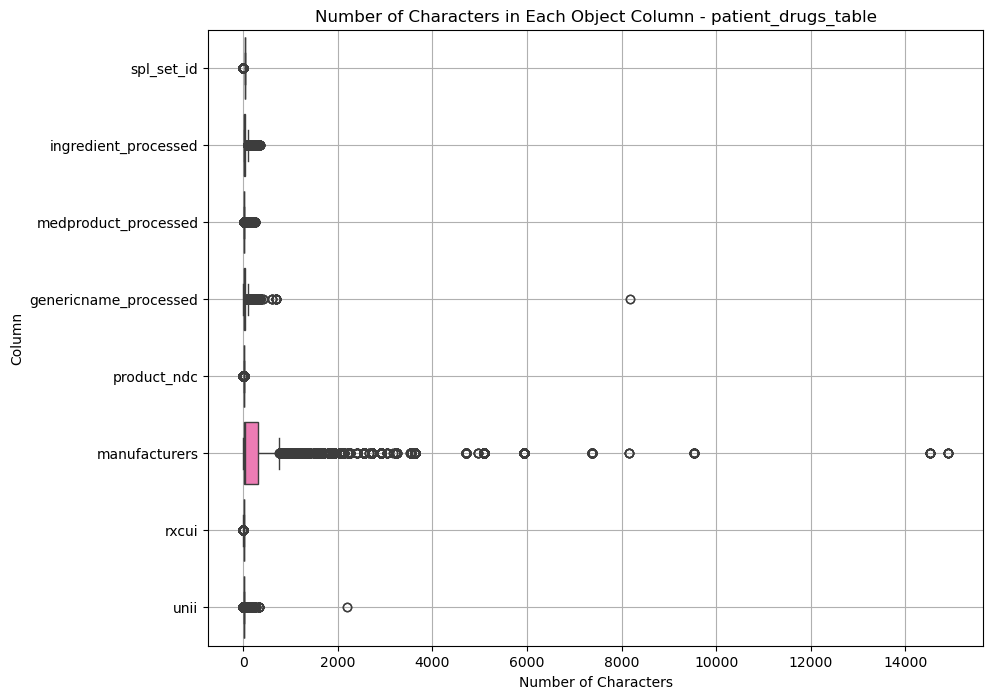


Descriptive Statistics on Character Length:
                          count        mean         std  min   25%   50%  \
spl_set_id             133423.0   31.275897   11.351437  4.0  36.0  36.0   
ingredient_processed   133423.0   30.243009   27.990315  8.0  14.0  16.0   
medproduct_processed   133423.0   23.009354   22.259957  7.0  12.0  15.0   
genericname_processed  133423.0   32.899058   51.722104  4.0  13.0  15.0   
product_ndc            133423.0    8.347421    1.830419  4.0   9.0   9.0   
manufacturers          133423.0  281.740315  742.586896  4.0  13.0  34.0   
rxcui                  133423.0    6.100290    1.036585  4.0   6.0   6.0   
unii                   133423.0   17.247484   26.684511  3.0  14.0  14.0   

                         75%      max  
spl_set_id              36.0     36.0  
ingredient_processed    45.0    354.0  
medproduct_processed    17.0    249.0  
genericname_processed   47.0   8187.0  
product_ndc              9.0     10.0  
manufacturers          311.0  

In [115]:
plot_character_length(patient_drugs_table, 'patient_drugs_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

**Examine 'Manufacturer' Outliers**
Reports contain manufacturers, distributors, and retail

In [116]:
patient_drugs_table_manufacturer_outliers = examine_text_outliers(patient_drugs_table['manufacturers'])
print(patient_drugs_table_manufacturer_outliers.iloc[2])

['kroger-company', 'lil-drug-store-products', 'target-corporation', 'sam-s-west-', 'teva-pharmaceuticals', 'safeway', 'safeway', 'bionpharma-', 'strategic-sourcing-services-', 'family-dollar-family-wellness-', 'big-lots-stores', 'dolgencorp', 'cvs-pharmacy', 'winco-foods', 'granules-india-', 'top-care-topco-associates-', 'heb', 'aurohealth-', 'marc-glassman', 'p-l-development', 'amerisource-bergen', 'valu-merchandisers-company', 'walgreen-company', 'topco-associates-', 'bayer-healthcare-', 'rite-aid-corporation', 'publix-supermarkets', 'medline-industries', 'granules-', 'new-world-imports', 'dolgencorp', '-dollar-general-rexall-', 'productos-zapotol-', 'belmora-', 'l-n-k-international', 'united-natural-foods', '-dba-unfi', 'meijer-distribution-', 'target-corporation', 'aurobindo-pharma-limited', 'wal-mart-stores-', 'l-perrigo-company', 'lidl-us-', 'amazon-com-services-', 'american-sales-company', 'lidl-us-', 'care-one-retail-business-services', 'athlete-s-needs-', 'target-corporation',

#### Convert Lists to Text

In [142]:
#columns_to_convert = ['indication', 'med_product', 'manufacturers','generic_name', 'product_type', 'unii', 'spl_set_id']
#columns_to_convert = ['indication', 'med_product', 'manufacturers', 'unii', 'spl_set_id']

#for col in columns_to_convert:
#    patient_drugs_table[col] = patient_drugs_table[col].apply(list_to_string)


#### Set Character Limits Based on 75% Percentile from Text Character Descriptive Plots

In [189]:
patient_drugs_table['manufacturers'] = patient_drugs_table['manufacturers'].apply(lambda x: x[:300] if isinstance(x, str) else x)

# Already reduced to 1 rxcui per entry so max amount of characters is 6 
#patient_drugs_table['rxcui'] = patient_drugs_table['rxcui'].apply(lambda x: x[:760] if isinstance(x, str) else x)

#patient_drugs_table['generic_name'] = patient_drugs_table['generic_name'].apply(lambda x: x[:300] if isinstance(x, str) else x)

patient_drugs_table['unii'] = patient_drugs_table['unii'].apply(lambda x: x[:20] if isinstance(x, str) else x)

# Removed this variable from primary data frame - too difficult to add to modeling
#patient_drugs_table['indication'] = patient_drugs_table['indication'].apply(lambda x: x[:150] if isinstance(x, str) else x)

### Save Final Data to Library

In [190]:
# Add unique ID
patient_drugs_table = add_sequential_index(patient_drugs_table,'patient_drug_id')

In [213]:
# Rename columns one last time
patient_drugs_table = patient_drugs_table.rename(columns={
    'med_product_processed': 'med_product',
    'ingredients_processed': 'ingredients',
    'generic_name_processed': 'generic_name'})

In [215]:
# Write the DataFrame to a CSV file
#patient_drugs_table.to_csv('DataLibrary/patient_drugs_table2023.csv', index=False)

In [214]:
patient_drugs_table.head()

,patient_drug_id,event_id,spl_set_id,ingredients,med_product,generic_name,manufacturers,manu_num,rxcui,unii,ndc9
0,1,1,ba74e3cd-b06f-4145-b284-5fd6b84ff3c9,"[dabigatran, etexilate, mesylate, dabigatran e...","[dabigatran, etexilate, mesylate, dabigatran e...","[dabigatran, etexilate, mesylate, dabigatran e...",[boehringer-ingelheim-pharmaceuticals-],1,1037045,[SC7NUW5IIT],05970108
1,9,2,2e5365ff-cb2a-4b16-b2c7-e35c6bf2de13,[tocilizumab],[actemra],[tocilizumab],[genentech],1,1441527,[I031V2H011],50242135
2,10,2,2e5365ff-cb2a-4b16-b2c7-e35c6bf2de13,[tocilizumab],[actemra],[tocilizumab],[genentech],1,1441527,[I031V2H011],50242135
3,11,2,2e5365ff-cb2a-4b16-b2c7-e35c6bf2de13,[tocilizumab],[actemra],[tocilizumab],[genentech],1,1441527,[I031V2H011],50242135
4,12,2,2e5365ff-cb2a-4b16-b2c7-e35c6bf2de13,[tocilizumab],[actemra],[tocilizumab],[genentech],1,1441527,[I031V2H011],50242135


In [216]:
# Save local as back up
patient_drugs_table.to_csv('C://Users/halee/Downloads/drugs_table2024_prep.csv', index=False)

## PreProcess Patient Reactions Table

### Rename Columns

In [132]:
patient_reactions_table = patient_reactions_df.rename(columns={
    'reactionmeddrapt': 'reaction',
    'reactionmeddraversionpt': 'version_medDRA',
    'reactionoutcome': 'outcome'
})

### Fix Dtypes

In [133]:
#n/a
#patient_reactions_table.head(10)
#patient_reactions_table.info()

### Feature Engineering

In [134]:
patient_reactions_table = add_sequential_index(patient_reactions_table,'patient_reaction_id')

In [135]:
patient_reactions_table.head()

,patient_reaction_id,event_id,version_medDRA,reaction,outcome
0,1,1,26.1,Blood pressure decreased,6
1,2,1,26.1,Disorientation,6
2,3,1,26.1,Speech disorder,6
3,4,1,26.1,Flushing,6
4,5,1,26.1,Nausea,6


### Map Features

In [136]:
#map outcomes to text categories

outcome_mapping = {
    1: 'Recovered',
    2: 'Recovering',
    3: 'NotRecovered',
    4: 'RecoveredWithSequelae',
    5: 'Fatal',
    6: 'Unknown'
}

# if outcome is 'Unknown', change to 6 (which will map to unknown again). Necessary that this column is int for mapping
patient_reactions_table.loc[patient_reactions_table['outcome'] == 'Unknown', 'outcome'] = 6

# Perform mapping by outcome mapping
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna(0).astype(int).map(outcome_mapping)

patient_reactions_table.tail()

,patient_reaction_id,event_id,version_medDRA,reaction,outcome
118516,118517,20885,26.1,Nasal congestion,Unknown
118517,118518,20885,26.1,Asthma,NotRecovered
118518,118519,20885,26.1,Drug hypersensitivity,Unknown
118519,118520,20885,26.1,Incorrect dose administered,Unknown
118520,118521,20885,26.1,Drug ineffective,Unknown


## LIST OF UNIQUE REACTIONS

Limit reactions to 64 characters (MySQL column name character length limit).

Filter for top 1000, since MySQL tables can only hold up to 1017 columns. 


In [137]:
# Step 1: Convert all reactions to lowercase
patient_reactions_table['reaction'] = patient_reactions_table['reaction'].str.lower()

# Step 2: Remove reactions with names longer than 64 characters
patient_reactions_table = patient_reactions_table[patient_reactions_table['reaction'].str.len() <= 64]

# Step 3: Get unique values from the 'reaction' column after filtering
unique_reactions_all = patient_reactions_table['reaction'].unique().tolist()

# Step 4: Count occurrences of each remaining reaction
reaction_counts = patient_reactions_table['reaction'].value_counts()

# Step 5: Get the top 1000 most common reactions
top_reactions = reaction_counts.head(1000)

# Step 6: Convert the results into a list of reactions
unique_reactions = top_reactions.index.tolist()

# Print the resulting list of top reactions (Optional)
print(unique_reactions)



['off label use', 'nausea', 'diarrhoea', 'fatigue', 'pyrexia', 'vomiting', 'dyspnoea', 'headache', 'rash', 'pruritus', 'pneumonia', 'covid-19', 'pain', 'neutropenia', 'asthenia', 'arthralgia', 'drug ineffective', 'malaise', 'dizziness', 'anaemia', 'weight decreased', 'condition aggravated', 'acute kidney injury', 'abdominal pain', 'cough', 'decreased appetite', 'weight increased', 'hypertension', 'thrombocytopenia', 'nasopharyngitis', 'inappropriate schedule of product administration', 'drug hypersensitivity', 'fall', 'infusion related reaction', 'erythema', 'hypotension', 'pain in extremity', 'general physical health deterioration', 'product dose omission issue', 'death', 'urinary tract infection', 'product use in unapproved indication', 'constipation', 'confusional state', 'sinusitis', 'infection', 'abdominal pain upper', 'urticaria', 'back pain', 'myelosuppression', 'insomnia', 'hypersensitivity', 'white blood cell count decreased', 'alopecia', 'peripheral swelling', 'febrile neutro

In [134]:
len(unique_reactions)

1000

### Save each reaction as binary column

In [140]:
for reaction in unique_reactions:
    patient_reactions_table[reaction] = 0

# Set the value to 1 if 'reaction' matches the column name
for idx, row in patient_reactions_table.iterrows():
    patient_reactions_table.loc[idx, reaction] = 1

patient_reactions_table.head()

,patient_reaction_id,event_id,version_medDRA,reaction,outcome,reaction_processed,off label use,nausea,diarrhoea,fatigue,...,fulminant type 1 diabetes mellitus,benign prostatic hyperplasia,inability to afford medication,erythema of eyelid,nerve injury,visual acuity reduced,tooth fracture,blood albumin decreased,bronchiolitis,blood magnesium decreased
0,1,1,26.1,blood pressure decreased,Unknown,"[blood, pressure, decreased]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,26.1,disorientation,Unknown,[disorientation],0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,1,26.1,speech disorder,Unknown,"[speech, disorder]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,26.1,flushing,Unknown,[flushing],0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,1,26.1,nausea,Unknown,[nausea],0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [136]:
#patient_reactions_table['sepsis']

In [169]:
patient_reactions_table.head()

,patient_reaction_id,event_id,version_medDRA,reaction,outcome,off label use,pyrexia,fatigue,nausea,diarrhoea,...,aspiration,tardive dyskinesia,erysipelas,oral discomfort,upper limb fracture,sleep disorder due to a general medical condition,intestinal dilatation,device malfunction,dialysis,cerebral haematoma
0,1,1,24.1,overdose,Recovered,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,24.1,acute hepatic failure,Recovered,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,1,24.1,cytomegalovirus infection,Unknown,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,2,24.1,haemorrhage intracranial,Fatal,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,2,24.1,overdose,Fatal,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Text Processing

#### Without MultiProcessing

In [139]:
#patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)
patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)

#### With MultiProcessing

In [171]:
start_time = time.time()

if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        patient_reactions_table['reaction_processed'] = pool.map(process_label_text, patient_reactions_table['reaction'])

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

1.111570119857788


#### Drop unprocessed reaction columns

In [141]:
patient_reactions_table = patient_reactions_table.drop('reaction', axis = 1)

### Examine Nulls

In [142]:
patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info

#fill the missing values in the outcome table with 'Unknown'
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna('Unknown')

patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info


,column_name,null_count,null_proportion
0,patient_reaction_id,0,0.0
1,event_id,0,0.0
2,version_medDRA,0,0.0
3,outcome,0,0.0
4,reaction_processed,0,0.0
...,...,...,...
1000,visual acuity reduced,0,0.0
1001,tooth fracture,0,0.0
1002,blood albumin decreased,0,0.0
1003,bronchiolitis,0,0.0


### Filter for Data Quality

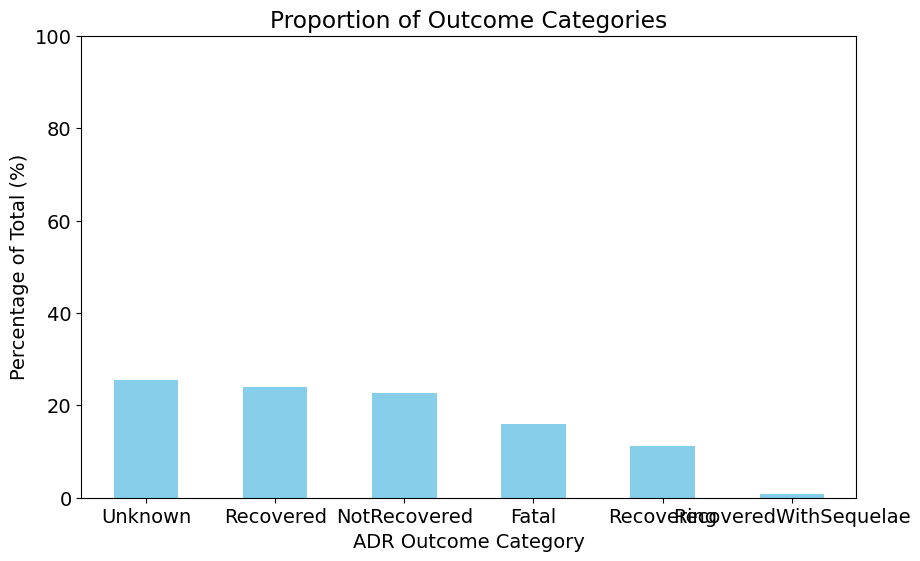

In [143]:
# Count the frequency of each category
category_counts = patient_reactions_table['outcome'].value_counts()

# Calculate the percentages
total = len(patient_reactions_table)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Outcome Categories')
plt.xlabel('ADR Outcome Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

In [144]:
patient_reactions_table['outcome'].value_counts()

outcome
Unknown                  30228
Recovered                28497
NotRecovered             26802
Fatal                    18830
Recovering               13165
RecoveredWithSequelae      988
Name: count, dtype: int64

In [145]:
patient_reactions_table['outcome'].value_counts(normalize=True)

outcome
Unknown                  0.255067
Recovered                0.240461
NotRecovered             0.226158
Fatal                    0.158890
Recovering               0.111088
RecoveredWithSequelae    0.008337
Name: proportion, dtype: float64

## Filter Data for Circular Analysis - Drop ADR Terms "Death"

In [146]:
patient_reactions_table.shape

(118510, 1005)

In [147]:
# Drop reaction terms containing the word death
patient_reactions_table = patient_reactions_table.loc[patient_reactions_table['reaction_processed'] != 'death']

In [148]:
patient_reactions_table.shape

(118510, 1005)

### Assess Text Field Lengths

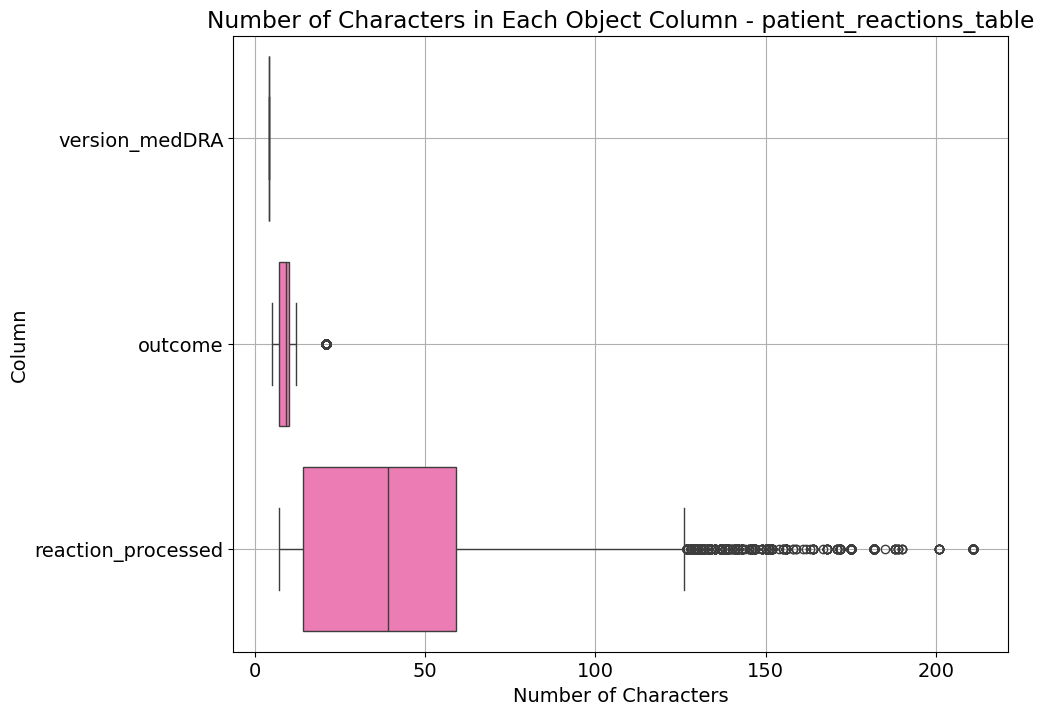


Descriptive Statistics on Character Length:
                       count       mean        std  min   25%   50%   75%  \
version_medDRA      112551.0   4.000000   0.000000  4.0   4.0   4.0   4.0   
outcome             112551.0   9.007037   2.517074  5.0   7.0   9.0  10.0   
reaction_processed  112551.0  41.567974  30.672520  7.0  14.0  39.0  59.0   

                      max  
version_medDRA        4.0  
outcome              21.0  
reaction_processed  211.0  


In [147]:
plot_character_length(patient_reactions_table, 'patient_reactions_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [149]:
reactions_table_text_processed_outliers = examine_text_outliers(patient_reactions_table['reaction_processed'])
print(reactions_table_text_processed_outliers)

6         [forced, expiratory, volume, decreased]
11          [increased, upper, airway, secretion]
39         [blood, pressure, systolic, increased]
40         [blood, pressure, systolic, decreased]
75        [blood, pressure, diastolic, increased]
                           ...                   
118455    [blood, pressure, diastolic, decreased]
118459    [blood, pressure, diastolic, decreased]
118475     [lower, respiratory, tract, infection]
118492     [blood, pressure, systolic, increased]
118501    [forced, expiratory, volume, decreased]
Name: reaction_processed, Length: 9256, dtype: object


In [150]:
patient_reactions_table[['patient_reaction_id','event_id','reaction_processed','outcome']].to_csv('C://Users/halee/Downloads/reaction_tokens.csv')

#### Drop reaction_processed

In [151]:
patient_reactions_table = patient_reactions_table.drop(columns=['reaction_processed'])

In [150]:
patient_reactions_table.head()

,patient_reaction_id,event_id,version_medDRA,outcome,off label use,nausea,diarrhoea,pyrexia,dyspnoea,vomiting,...,splenomegaly,photosensitivity reaction,torsade de pointes,intestinal ischaemia,metastases to bone,incorrect dosage administered,low birth weight baby,sedation,full blood count abnormal,reaction_processed
0,1,1,26.1,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"[aortic, dissection, aortic dissection]"
1,2,1,26.1,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,[haemorrhage]
2,3,1,26.1,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"[disseminated, intravascular, coagulation, dis..."
3,4,1,26.1,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"[shock, haemorrhagic, shock haemorrhagic]"
4,5,1,26.1,Recovering,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"[cardiac, arrest, cardiac arrest]"


In [151]:
# Write the DataFrame to a CSV file
#patient_reactions_table.to_csv('DataLibrary/reactions_table2023.csv', index=False)

In [152]:
# Save local as back up
patient_reactions_table.to_csv('C://Users/halee/Downloads/reactions_table2024.csv', index=False)

## PreProcess Prices Table

In [ ]:
# Get list of price information for each unique ndc11 value in table, i.e., avoiding duplicate API requests
drug_prices = fetch_nadac_data(patient_drugs_table['ndc11'].unique())

In [ ]:
drug_prices = prices_df

### Select Columns

In [183]:
prices_table = pd.DataFrame(prices_df, 
                            columns = [#"NDC Description",  # Identifies the drug name/dosage, Redundant Information with labels_table
                                       "NDC",  # 11 character FDA code, Do NOT Tokenize, database key
                                       "NADAC_Per_Unit",  #  The National Average Drug Acquisition Cost per unit, do NOT tokenize
                                       "Effective Date",  # The effective date of the NADAC Per Unit cost
                                        #"Pricing_Unit",  # Pricing unit for NDC ('ML', 'GM 'or 'EA'), Not necessary, just use price
                                        #"Pharmacy_Type_Indicator",  # 'C/I' data from Chain/Independent pharmacies, does not provide helpful info
                                        #"OTC",  # Indicates whether NDC is over-the-counter (OTC), redundant with labels_table
                                        #"Explanation Code",  # NADAC Calculation Method, not necessary for this project, too much missing data
                                                                       # Code 1: Inform from most recent survey.
                                                                       # Code 2: Cost within ± 2%, carried forward from previous
                                                                       # Code 3: Published pricing, or help desk inquiry
                                                                       # Code 4: Carried forward from previous year
                                                                       # Code 5: Based on package size.
                                                                       # Code 6: CMS Covered Outpatient Drug Product File drug category 
                                        "Classification_for_Rate_Setting",  # B: brand, 
                                                                            # G: generic
                                                                            # B-ANDA: brand under ANDA
                                                                            # B-BIO: biosimilar brand  
                                        #"Corresponding_Generic_Drug_NADAC_Per_Unit",
                                        #"Corresponding_Generic_Drug_Effective_Date"
                                        #"As of Date"
                                      ])

#prices_table = prices_table[['NDC', 'NADAC_Per_Unit', 'Effective Date', 'Classification_for_Rate_Setting', 
#                             'Corresponding_Generic_Drug_NADAC_Per_Unit', 'Corresponding_Generic_Drug_Effective_Date']]


NameError: name 'prices_df' is not defined

In [ ]:
#prices_table = pd.read_csv('DataLibrary/prices_table.csv')

In [ ]:
prices_table.head()

### Fix Dtypes

In [334]:
prices_table['Effective Date'] = pd.to_datetime(prices_table['Effective Date'])
prices_table['year'] = prices_table['Effective Date'].dt.year
#prices_table['Corresponding_Generic_Drug_Effective_Date'] = pd.to_datetime(prices_table['Corresponding_Generic_Drug_Effective_Date'])
prices_table['NADAC_Per_Unit'] = prices_table['NADAC_Per_Unit'].astype(float)

KeyError: 'Effective Date'

### Examine Nulls

In [453]:
# replace empty strings with nan
prices_table = prices_table.replace(r'^\s*$', np.nan, regex=True)

prices_nan = nan_info(prices_table)
prices_nan

,column_name,null_count,null_proportion
0,ndc11,0,0.0
1,unit_price,0,0.0
2,year,0,0.0
3,generic_brand,0,0.0


### Feature Engineering 

In [442]:
prices_table['Classification_for_Rate_Setting'].value_counts()

KeyError: 'Classification_for_Rate_Setting'

In [ ]:
# Update classification to binary generic/brand, G:1 B:0
prices_table['Classification_for_Rate_Setting'] = prices_table['Classification_for_Rate_Setting'].apply(lambda x: 1 if x == 'G' else 0)

In [448]:
# Add index column
prices_table = add_sequential_index(prices_table, 'price_id')
prices_table.head()

,price_id,ndc11,unit_price,year,generic_brand
0,1,24385005452,0.28255,2022,1
1,2,70000047501,0.28255,2022,1
2,3,46122038576,0.78326,2022,1
3,4,70000036201,0.15365,2022,1
4,5,70000036202,0.15365,2022,1


### Create new column for ndc9

In [454]:
prices_table.head()
prices_table['ndc11'] = prices_table['ndc11'].astype(str)
prices_table['ndc9'] = prices_table['ndc11'].str[:-2]
prices_table.head()

,ndc11,unit_price,year,generic_brand,ndc9
0,24385005452,0.28255,2022,1,243850054
1,70000047501,0.28255,2022,1,700000475
2,46122038576,0.78326,2022,1,461220385
3,70000036201,0.15365,2022,1,700000362
4,70000036202,0.15365,2022,1,700000362


### Rename Columns

In [455]:
prices_table = prices_table.rename(columns = {'NDC': 'ndc11',
                         'NADAC_Per_Unit': 'unit_price',
                         'Effective Date': 'price_date',
                         'Classification_for_Rate_Setting': 'generic_brand',
                         'Corresponding_Generic_Drug_NADAC_Per_Unit': 'generic_price',
                         'Corresponding_Generic_Drug_Effective_Date': 'generic_date'})

In [456]:
prices_table = prices_table[['ndc11',
                             'ndc9',
                            'unit_price',
                            'year',
                            'generic_brand']]

In [457]:
prices_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ndc11          10000 non-null  object 
 1   ndc9           10000 non-null  object 
 2   unit_price     10000 non-null  float64
 3   year           10000 non-null  int64  
 4   generic_brand  10000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 390.8+ KB


In [458]:
prices_table.head()

,ndc11,ndc9,unit_price,year,generic_brand
0,24385005452,243850054,0.28255,2022,1
1,70000047501,700000475,0.28255,2022,1
2,46122038576,461220385,0.78326,2022,1
3,70000036201,700000362,0.15365,2022,1
4,70000036202,700000362,0.15365,2022,1


In [459]:
# Write the DataFrame to a CSV file
prices_table.to_csv('DataLibrary/prices_table.csv', index=False)

## Preprocess Documents Table

### Select Columns

In [ ]:
documents_table = pd.DataFrame(documents_df, columns=["doc_type", "year", "text"])

documents_table = add_sequential_index(documents_table,'doc_id')


### Fix Dtypes

### Match Drugs Present in Text

In [ ]:
def find_matching_drugs(text, unique_drug_names):
    matched_drugs = []
    for drug in unique_drug_names:
        if drug.lower() in text.lower():
            matched_drugs.append(drug)
    return matched_drugs


#### Without MultiProcessing

In [ ]:
start_time = time.time()
# Create 'matching_drugs' column using apply
documents_table['matching_drugs'] = documents_table['text'].apply(lambda x: find_matching_drugs(x, unique_drug_names))

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### With MultiProcessing

In [440]:
# Figure out how to apply
# Create a pool with the same number of workers as CPU cores

start_time = time.time()


if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        documents_table['matching_drugs'] = pool.starmap(find_matching_drugs, zip(documents_table['text'], [unique_drug_names]*len(documents_table)))

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

Process SpawnPoolWorker-177:
Traceback (most recent call last):
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'find_matching_drugs' on <module '__main__' (built-in)>
Process SpawnPoolWorker-176:
Traceback (most recent call last):
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vicky

KeyboardInterrupt: 

### Match Reactions Present in Text

In [ ]:
# Function to check for matches between text and unique_reactions
def check_reactions(text, unique_reactions):
    text_lower = text.lower()
    matches = [1 if reaction.lower() in text_lower else 0 for reaction in unique_reactions]
    return matches

In [ ]:
documents_table.head()

### Generate binary column for each reaction

In [444]:
# Apply the function across the dataframe to populate binary columns
documents_table[unique_reactions] = documents_table['text'].apply(lambda x: pd.Series(check_reactions(x, unique_reactions)))

# Text column no longer needed
documents_table.drop(columns=['text'], inplace=True)

# Function to return matching reactions as a list
def get_matching_reactions(row, unique_reactions):
    matching_reactions = [reaction for reaction in unique_reactions if row[reaction] == 1]
    return matching_reactions

# Create 'all_reactions' column by applying the function row-wise
documents_table['all_reactions'] = documents_table.apply(lambda row: get_matching_reactions(row, unique_reactions), axis=1)

documents_table.head()

,doc_id,doc_type,year,matching_drugs,off label use,fatigue,pyrexia,diarrhoea,nausea,dyspnoea,...,upper respiratory tract inflammation,foetal death,sensory disturbance,incontinence,foot fracture,autoimmune disorder,autoimmune hepatitis,localised oedema,peripheral coldness,all_reactions
0,1,pr,2014,"[health, body]",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[fatigue, rash, infection, upper respiratory t..."
1,2,pr,2014,"[ibu, health, body]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[pain, insomnia, anxiety, chest pain, tachycar..."
2,3,pr,2013,[health],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[mental disorder]
3,4,pr,2013,"[ibu, health]",0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[nausea, pain, headache, vomiting, abdominal p..."
4,5,pr,2014,"[ibu, health]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[illness]


In [445]:
# apply parallel processing

### Explode Table by Reaction 

In [446]:
# Explode the dataframe based on reaction; makes a new row for each reaction in the list
documents_table = documents_table.explode('matching_drugs').reset_index(drop=True)

### Rename columns

In [447]:
documents_table.rename(columns={'matching_drugs': 'drug'}, inplace=True)
documents_table.head()

,doc_id,doc_type,year,drug,off label use,fatigue,pyrexia,diarrhoea,nausea,dyspnoea,...,upper respiratory tract inflammation,foetal death,sensory disturbance,incontinence,foot fracture,autoimmune disorder,autoimmune hepatitis,localised oedema,peripheral coldness,all_reactions
0,1,pr,2014,health,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[fatigue, rash, infection, upper respiratory t..."
1,1,pr,2014,body,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[fatigue, rash, infection, upper respiratory t..."
2,2,pr,2014,ibu,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[pain, insomnia, anxiety, chest pain, tachycar..."
3,2,pr,2014,health,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[pain, insomnia, anxiety, chest pain, tachycar..."
4,2,pr,2014,body,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[pain, insomnia, anxiety, chest pain, tachycar..."


### Fix Dtypes

In [448]:
numeric_columns = documents_table.drop(columns=['doc_id', 'doc_type', 'year', 'drug'])
numeric_columns = numeric_columns.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coerce errors to NaN

In [449]:
#documents_table.dtypes

### Drop all reactions column

In [450]:
documents_table.drop(columns=['all_reactions'], inplace=True)


### Add new additional id column

In [451]:
documents_table.head()
documents_table = add_sequential_index(documents_table, 'id')

### Save as CSV for Data Exploration

In [452]:
documents_table.to_csv('documents_table.csv', index=False)

## Preprocess Manufacturers Table

In [347]:
manus_df.columns

NameError: name 'manus_df' is not defined

### Select Columns

In [ ]:
# Choose values to help fill in missing data from other tables
manus_table = pd.DataFrame(manus_df, 
                           columns=["product_ndc",
                                    "generic_name",
                                    "brand_name",
                                    "openfda.manufacturer_name",
                                   "spl_id",
                                   "openfda.spl_set_id",
                                   "openfda.unii",
                                   "marketing_start_date"])  # Update to expiration date

### Feature Engineering

In [ ]:
manus_table = add_sequential_index(manus_table,'manu_id')

In [ ]:
manus_table['year'] = pd.to_datetime(manus_table['marketing_start_date']).dt.year

### Examine Nulls

In [ ]:
manus_nan = nan_info(manus_table)
manus_nan

### Fix Dtypes

### Text Processing

In [ ]:
manus_table['drug_names'] = manus_table['generic_name']+ " " + manus_table['brand_name']

In [ ]:
manus_table['drug_names_processed'] = manus_table['drug_names'].apply(process_label_text).apply(remove_duplicates_nan)
manus_table[['drug_names', 'drug_names_processed']].head(10)

In [ ]:
manus_table['manufacturers'] = manus_table['openfda.manufacturer_name'].apply(clean_manufacturer_text)
manus_table[['openfda.manufacturer_name', 'manufacturers']].head(10)

In [ ]:
manus_table_rxcui_outliers = examine_text_outliers(manus_table['manufacturers'])
print(manus_table_rxcui_outliers)

### Rename and Select Columns

In [ ]:
manus_table = manus_table.rename(columns = {'product_ndc': 'ndc',
                         'drug_names_processed': 'drug_names',
                         'openfda.spl_set_id': 'set_id',
                         'openfda.unii': 'unii'})

In [ ]:
manus_table = manus_table[['manu_id',
                           'spl_id',
                           'ndc',
                           'year',
                          'drug_names',
                          'set_id',
                          'unii',
                           'drug_names',
                          'manufacturers']]

### Assess Text Field Lenghts

In [ ]:
plot_character_length(manus_table, 'manus_table')

In [ ]:
# Write the DataFrame to a CSV file
#manus_table.to_csv('DataLibrary/manus_table.csv', index=False)

# Standardization and Normalization
* Use Parallel Processing

## Read in ADReCS Files

In [349]:
adrecs_drugs = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drugs.head()

,DRUG_ID,DRUG_NAME,DRUG_SYNONYMS,DrugBank_ID,PubChem_ID,MESH_ID,KEGG_ID,TTD_ID
0,BADD_D00001,"1,2-hexanediol","1,2-hexanediol",DB14108,94335,C119102,Not Available,Not Available
1,BADD_D00002,2-hydroxy-3-phenylpropanoic acid,"3-phenyllactic acid | 3-phenyllactic acid, mon...",Not Available,3848,C017648,Not Available,Not Available
2,BADD_D00003,2-phenylbutyric acid,2-phenylbutyric acid | 2-phenylbutanoic acid,Not Available,7012,C039714,Not Available,Not Available
3,BADD_D00004,2-[1-methyl-5-(4-methylbenzoyl)pyrrol-2-yl]ace...,"Tolmetin | Tolectin | Tolmetin Sodium, Anhydro...",DB00500,5508,D014046,D00158; D02355,D09BHB
4,BADD_D00005,4-oxo-3-(3-oxo-1-phenylbutyl)chromen-2-olate,Warfarin | 4-Hydroxy-3-(3-oxo-1-phenylbutyl)-2...,DB00682,23690541,D014859,D00564; D08682; D01280,D0E3OF


In [350]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

,ADRECS_ID,ADR_ID,ADR_TERM,ADR_SYNONYMS,MEDDRA_CODE
0,01,BADD_A00503,Blood and lymphatic system disorders,Not Available,10005329
1,01.01,BADD_A06244,Coagulopathies and bleeding diatheses (excl th...,Not Available,10064477
2,01.01.01,BADD_A00960,Coagulation factor deficiencies,Not Available,10009737
3,01.01.01.001,BADD_A02211,Hypoprothrombinaemia,Exaggerated hypoprothrombinaemia | Hypoprothro...,10021085
4,01.01.01.002,BADD_A05294,Acquired haemophilia,Acquired haemophilia | Acquired hemophilia | A...,10053745


## Standardize Drug Names into Primary Ingredient Compounds
* Based on 90% string match between FAERS reported medicinal product and ADReCS classification data

In [351]:
# Reactions table test set
drugs_test = pd.read_csv('DataLibrary/drugs_table.csv').iloc[0:80, ]
drugs_test

,patient_drug_id,event_id,spl_set_id,indication,med_product,generic_name,manufacturers,manu_num,product_type,rxcui,rxcui_num,unii
0,1,1,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
1,2,2,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
2,3,3,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
3,4,4,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
4,5,5,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
5,6,6,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
6,7,7,"['adc84ad5-a04d-4fee-9ba8-91f7abd928e3', 'd592...","chronic, myeloid, leukaemia, chronic myeloid, ...",bosutinib,bosutinib,"pfizer-laboratories-div-pfizer-, u-s-pharmaceu...",2,"human, prescription, drug, human prescription,...",1307624.0,7,844ZJE6I55
7,8,8,['17f85d17-ab71-4f5b-9fe3-0b8c822f69ff'],"breast, cancer, breast cancer",pertuzumab,pertuzumab,genentech,1,"human, prescription, drug, human prescription,...",1298948.0,7,K16AIQ8CTM
8,9,8,['17f85d17-ab71-4f5b-9fe3-0b8c822f69ff'],NaN,pertuzumab,pertuzumab,genentech,1,"human, prescription, drug, human prescription,...",1298948.0,7,K16AIQ8CTM
9,10,8,['17f85d17-ab71-4f5b-9fe3-0b8c822f69ff'],NaN,pertuzumab,pertuzumab,genentech,1,"human, prescription, drug, human prescription,...",1298948.0,7,K16AIQ8CTM


In [352]:
from pathos.multiprocessing import ProcessingPool as Pool
import pandas as pd
import numpy as np
import multiprocessing as mp
from fuzzywuzzy import process
import time

In [353]:
def process_and_normalize_drugs(df_chunk, df2_synonyms, df2_names):
    def drug_name_norms(row):
        med_product_list = str(row['med_product']).split(' \, ')
        med_product_list = list(set(med_product_list))  # unique values
        synonyms_list = list(set(' '.join(df2_synonyms).split(' \| ')))  # unique values
        match = process.extractOne(' '.join(med_product_list), synonyms_list)
        if match and match[1] > 90:
            original_row_index = df2_synonyms[df2_synonyms.str.contains(match[0], regex=False)].index
            if not original_row_index.empty:
                return df2_names.iloc[original_row_index[0]]
        return None

    df_chunk['drug_name_norm'] = df_chunk.apply(drug_name_norms, axis=1)
    return df_chunk

def parallel_worker(chunk, func, args):
    return func(chunk, *args)

def apply_parallel(df, func, args):
    df_split = np.array_split(df, mp.cpu_count())
    with mp.Pool(mp.cpu_count()) as pool:
        result = pd.concat(pool.starmap(parallel_worker, [(chunk, func, args) for chunk in df_split]))
    return result

if __name__ == '__main__':

    start_time = time.time()

    # Apply the parallel processing
    result_table = apply_parallel(drugs_test, process_and_normalize_drugs, (adrecs_drugs['DRUG_SYNONYMS'], adrecs_drugs['DRUG_NAME']))

    # Combine the result into a single column in the original table
    drugs_test['drug_name_norm'] = result_table['drug_name_norm']

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

Process SpawnPoolWorker-5:
Traceback (most recent call last):
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'parallel_worker' on <module '__main__' (built-in)>
Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vicky/opt/ana

KeyboardInterrupt: 

In [354]:
drugs_test[['med_product', 'drug_name_norm']].head(10)

KeyError: "['drug_name_norm'] not in index"

### Create Drug Compound Binary Matrix

## Filling in Missing Data Across Tables - May be Able to Delete and Use RxNorm API retrieve

#### Create Smaller Samples for Testing 

In [ ]:
labels_test = pd.read_csv('DataLibrary/labels_table.csv').iloc[0:50,]
drugs_test = pd.read_csv('DataLibrary/drugs_table.csv').iloc[0:50,]

#### Remove punctuation from set_id, ndc codes, unii, to standardize across tables

In [ ]:
# Function to standardize NDC format
def remove_punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))


# Apply to both dataframes
labels_test['ndc'] = labels_test['ndc'].astype(str).apply(remove_punctuation)
manus_table['ndc'] = manus_table['ndc'].astype(str).apply(remove_punctuation)
labels_test['set_id'] = labels_test['set_id'].astype(str).apply(remove_punctuation)
manus_table['set_id'] = manus_table['set_id'].astype(str).apply(remove_punctuation)


#### Check for matching NDC codes across sources

In [ ]:
def find_matches(list1, list2):

     # Convert inner lists to tuples to make them hashable
    set1 = set(tuple(x) if isinstance(x, list) else x for x in list1)
    set2 = set(tuple(x) if isinstance(x, list) else x for x in list2)
    
    # Find the intersection of the two sets
    common_elements = set1.intersection(set2)
    
    # Convert the set back to a list
    return list(common_elements)

list1 = manus_table['set_id'].tolist()
list2 = labels_test['set_id'].tolist()

matches = find_matches(list1, list2)
matches

### Manufacturer Table Contains 100% of NDC code for all actively marketed drugs
* Create dictionary pairs to map and fill in missing data for dictionary method

In [ ]:
# Fill in missing unii and spl_set_id with zeros to create dictionaries
manus_table['unii'] = manus_table['unii'].fillna(0)
manus_table['set_id'] = manus_table['set_id'].fillna(0)

In [ ]:
# Dictionary of ndc and spl_id
manu_ndc_spl_dict = dict(zip(manus_table['ndc'], manus_table['spl_id']))

In [ ]:
# Dictionary of ndc code and unii
manu_ndc_unii_dict = dict(zip(manus_table['ndc'], manus_table['unii']))

In [ ]:
# Dictionary of ndc code and spl_set_id
manu_ndc_set_dict = dict(zip(manus_table['ndc'],manus_table['set_id']))

In [ ]:
# Time it
start_time = time.time()

# Create reverse mapping from set_id to ndc
reverse_mapping = {}
for ndc, set_ids in manu_ndc_set_dict.items():
    if isinstance(set_ids, list):
        for set_id in set_ids:
            reverse_mapping[set_id] = ndc

# Function to fill NaN values in 'ndc' based on 'set_id'
def fillna_ndc_with_setid(row, reverse_dict):
    if pd.isna(row['ndc']) and row['set_id'] in reverse_dict:
        return reverse_dict[row['set_id']]
    return row['ndc']

# Apply the function to fill NaN values in 'ndc'
labels_test['ndc'] = labels_test.apply(lambda row: fillna_ndc_with_setid(row, reverse_mapping), axis = 1)

In [ ]:
# Look up specific set_ids and ndc in manus_table to confirm proper matching
ndc_check = manus_table.loc[manus_table['set_id'] == "000155a8709c44e5a75fcd890f3a7caf", 'ndc'].values
ndc_check

### Generate Year Helper Table

In [152]:
years = list(range(1900, 2051))
year_table = pd.DataFrame({'year': years})

# Combining Data into SQL Database Based on Keys

## Create new database to store data

In [3]:
# connect to MySQL server
connection = mysql.connector.connect(host="localhost", user="root", password=PASSWORD)

# Create a cursor object
cursor = connection.cursor()

# Drop the database if it exists - this is so we can start fresh (at least while developing)
cursor.execute("DROP DATABASE IF EXISTS pharma_db")

# Create the 'covid_db' database
cursor.execute("CREATE DATABASE pharma_db")

# Switch to the 'covid_db' database
cursor.execute("USE pharma_db")

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Create Read-Only User Access for Public

In [187]:
# public username and password

### Create Edit Privelages for Us

In [188]:
# private username and password

## Create datframes from API request dataframes

#### First remove all column  names with > 64 characters due to limit

Some unique reactions are too long

In [4]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

#--------------------------------------------------------------------------

#Create year table
create_year_query = """
CREATE TABLE IF NOT EXISTS `year` (
  `year` INT(4),
  PRIMARY KEY (`year`)
) ENGINE=InnoDB;
"""
cursor.execute(create_year_query)


# Create documents table
documents_table_csv = pd.read_csv('documents_table.csv')

# Define specific columns and their data types
documents_specific_columns = {
    'id': 'INT NOT NULL',
    'doc_id': 'INT NOT NULL',
    'doc_type': 'VARCHAR(4)',
    'year': 'INT(4)',
    'drug': 'VARCHAR(100)'
}

# Generate column definitions for unspecified columns as BOOLEAN
column_definitions = [
    f"`{re.sub(r'[^a-zA-Z0-9]', '_', col)}` BOOL"  # Replace non-alphanumeric characters with underscore
    for col in documents_table_csv.columns if col not in documents_specific_columns
]

# Combine all column definitions into the CREATE TABLE query
create_documents_table_query = f"""
CREATE TABLE IF NOT EXISTS `documents` (
  {", ".join([f"`{col}` {documents_specific_columns.get(col, 'BOOL')}" for col in documents_table_csv.columns])},
  PRIMARY KEY(`id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
) ENGINE=InnoDB;
"""

cursor.execute(create_documents_table_query)
#----------------------------------------------------------------------
# Create adverse events table
create_events_query = """
CREATE TABLE IF NOT EXISTS `adverse_events` (
  `event_id` INT,
  `safetyreportid` VARCHAR(9),
  `year` INT(4),
  `serious_outcome` TINYINT,
  `expedited` BOOLEAN,
  `report_source` INT,
  `country` VARCHAR(25),
  `age` INT,
  `sex` INT,
  `weight` INT,
  `company_name` VARCHAR(200),
  PRIMARY KEY (`event_id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
) ENGINE=InnoDB;
"""
cursor.execute(create_events_query)

# Create patient_reactions table ------------------------


patient_reactions_table_csv = pd.read_csv('C://Users/halee/Downloads/reactions_table2023.csv')


# Define specific columns and their data types

patient_reactions_specific_columns = {
 'patient_reaction_id': 'INT NOT NULL',
  'event_id' : 'INT',
  'version_medRNA' : 'VARCHAR(4)',
  'outcome': 'VARCHAR(50)'
}
  
#Generate column definitions for unspecified columns as BOOLEAN
patient_reactions_column_definitions = [
    f"`{re.sub(r'[^a-zA-Z0-9]', '_', col)}` BOOL"  # Replace non-alphanumeric characters with underscore
    for col in patient_reactions_table_csv.columns if col not in patient_reactions_specific_columns
]

# Combine all column definitions into the CREATE TABLE query
create_patient_reactions_query = f"""
CREATE TABLE IF NOT EXISTS `patient_reactions` (
  {", ".join([f"`{col}` {patient_reactions_specific_columns.get(col, 'BOOL')}" for col in patient_reactions_table_csv.columns])},
  PRIMARY KEY(`patient_reaction_id`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ON DELETE CASCADE,
  INDEX(`event_id`)
  ) ENGINE=InnoDB;
"""

cursor.execute(create_patient_reactions_query)

#-------------------------------------------

# Create labels table
create_labels_query = """
CREATE TABLE IF NOT EXISTS `labels` (
  `set_id` VARCHAR(100),
  `label_id` INT NOT NULL AUTO_INCREMENT,
  `year` INT(4),
  `ndc9` INT(11), 
  `rxcui` VARCHAR(200),
  `unii` VARCHAR(150),
  `label_date` DATE,
  `ingredients` VARCHAR(5000),
  `warnings` TEXT(20000),
  `drug_names` VARCHAR(7500),
  `purpose` VARCHAR(2200),
  PRIMARY KEY(`label_id`),
  INDEX(`ndc9`),
  INDEX(`rxcui`)
) ENGINE=InnoDB;
"""
cursor.execute(create_labels_query)

# Create patient_drugs table

#temporarily removed on delete cascade foreign key constraint for event_id for troubleshooting
create_patient_drugs_query = """
CREATE TABLE IF NOT EXISTS `patient_drugs` (
 `patient_drug_id` INT NOT NULL AUTO_INCREMENT,
  `event_id` INT,
  `med_product` VARCHAR(250),
  `generic_name` VARCHAR(300),
  `ingredients` VARCHAR(1000),
  `manufacturers` VARCHAR(5000),
  `manu_num` INT,
  `rxcui` VARCHAR(760),
  `unii` VARCHAR(150),
  `ndc9` INT(11),
  PRIMARY KEY(`patient_drug_id`),
  INDEX(`event_id`),
  INDEX(`rxcui`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_patient_drugs_query)

create_prices_query = """
CREATE TABLE IF NOT EXISTS `prices` (
 `price_id` INT NOT NULL AUTO_INCREMENT,
  `ndc11` VARCHAR(11),
  `ndc9` INT(11),
  `unit_price` VARCHAR(20),
  `price_date` DATE,
  `generic_brand` BOOLEAN,
  `year` INT(4),
  PRIMARY KEY(`price_id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
  ON DELETE CASCADE,
  INDEX(`ndc9`)
) ENGINE=InnoDB;
"""
cursor.execute(create_prices_query)


# Create drug_names table
create_drug_names_query = """
CREATE TABLE IF NOT EXISTS `drug_names` (
  `drug_name_id` INT NOT NULL AUTO_INCREMENT,
  `label_id` INT,
  `rxcui` VARCHAR(100),
  `ndc9` INT(11),
  `ingredients` VARCHAR(1000),
  PRIMARY KEY(`drug_name_id`),
  FOREIGN KEY (`ndc9`) REFERENCES `labels` (`ndc9`),
  FOREIGN KEY (`ndc9`) REFERENCES `prices` (`ndc9`),
  FOREIGN KEY (`rxcui`) REFERENCES `patient_drugs` (`rxcui`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_drug_names_query)

# show tables below
cursor.execute("SHOW TABLES")

# Fetch all the rows
tables = cursor.fetchall()

# Print the list of tables
for table in tables:
    print(table[0])

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

adverse_events
documents
drug_names
labels
patient_drugs
patient_reactions
prices
year


In [24]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

#temporarily removed on delete cascade foreign key constraint for event_id for troubleshooting
create_patient_drugs_query = """
CREATE TABLE IF NOT EXISTS `patient_drugs` (
 `patient_drug_id` INT NOT NULL AUTO_INCREMENT,
  `event_id` INT,
  `med_product` VARCHAR(250),
  `generic_name` VARCHAR(300),
  `ingredients` VARCHAR(1000),
  `manufacturers` VARCHAR(5000),
  `manu_num` INT,
  `rxcui` VARCHAR(760),
  `unii` VARCHAR(150),
  `ndc9` INT(10),
  PRIMARY KEY(`patient_drug_id`),
  INDEX(`event_id`),
  INDEX(`rxcui`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_patient_drugs_query)

## Bulk Import Data from Dataframes

### Year Table

#### Import data

In [5]:
years = list(range(1900, 2051))
year_table = pd.DataFrame({'year': years})

user = 'root'
password = PASSWORD
host = 'localhost'
database = 'pharma_db'
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}', echo=False)

year_table.to_sql('year', con=engine, if_exists='append', index=False)

151

#### Preview Year Table

In [6]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM year LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,year
0,1900
1,1901
2,1902
3,1903
4,1904


### Documents Table

#### Import Data

In [7]:

start_time = time.time()

#read in csv
documents_table_csv = pd.read_csv('documents_table.csv')
documents_table_csv.to_sql('documents', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)
#documents_table.to_sql('documents', con=connection, if_exists='append', index=False)

114.60492634773254


#### Preview Documents Table

In [8]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM documents LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,id,doc_id,doc_type,year,drug,off label use,fatigue,pyrexia,diarrhoea,nausea,...,post procedural complication,upper respiratory tract inflammation,foetal death,sensory disturbance,incontinence,foot fracture,autoimmune disorder,autoimmune hepatitis,localised oedema,peripheral coldness
0,1,1,pr,2014,health,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,pr,2014,body,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2,pr,2014,ibu,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2,pr,2014,health,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2,pr,2014,body,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Events Table

#### Import Data

In [9]:
start_time = time.time()

events_table_csv = pd.read_csv('DataLibrary/events_table2023.csv')
events_table_csv.to_sql('adverse_events', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

7.389038801193237


#### Preview Events Table

In [10]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM adverse_events LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,event_id,safetyreportid,year,serious_outcome,expedited,report_source,country,age,sex,weight,company_name
0,1,None,2024,2,1,1,jp,84,2,50,['nbi']
1,2,None,2024,1,1,3,ca,71,2,77,['roche']
2,3,None,2024,1,1,3,ca,46,1,100,['roche']
3,4,None,2024,1,1,2,nl,81,2,56,['amgen']
4,5,None,2024,2,1,1,it,68,1,77,['pubhosp']


### Patient Drugs Table

#### Import data

In [25]:
patient_drugs_table_csv = pd.read_csv('C://Users/halee/Downloads/drugs_table2023.csv')
patient_drugs_table_csv = patient_drugs_table_csv.drop(columns=['spl_set_id'])
patient_drugs_table_csv.to_sql('patient_drugs', con=engine, if_exists='append', index=False)

IntegrityError: (mysql.connector.errors.IntegrityError) 1062 (23000): Duplicate entry '1' for key 'patient_drugs.PRIMARY'
[SQL: INSERT INTO patient_drugs (patient_drug_id, event_id, ingredients, med_product, generic_name, manufacturers, manu_num, rxcui, unii, ndc9) VALUES (%(patient_drug_id)s, %(event_id)s, %(ingredients)s, %(med_product)s, %(generic_name)s, %(manufacturers)s, %(manu_num)s, %(rxcui)s, %(unii)s, %(ndc9)s)]
[parameters: [{'patient_drug_id': 1, 'event_id': 1, 'ingredients': "['dabigatran', 'etexilate', 'mesylate', 'dabigatran etexilate', 'etexilate mesylate']", 'med_product': "['dabigatran', 'etexilate', 'mesylate', 'dabigatran etexilate', 'etexilate mesylate']", 'generic_name': "['dabigatran', 'etexilate', 'mesylate', 'dabigatran etexilate', 'etexilate mesylate']", 'manufacturers': "['boehringer-ingelheim-pharmaceuticals-']", 'manu_num': 1, 'rxcui': 1037045.0, 'unii': "['SC7NUW5IIT']", 'ndc9': 5970108.0}, {'patient_drug_id': 9, 'event_id': 2, 'ingredients': "['tocilizumab']", 'med_product': "['actemra']", 'generic_name': "['tocilizumab']", 'manufacturers': "['genentech']", 'manu_num': 1, 'rxcui': 1441527.0, 'unii': "['I031V2H011']", 'ndc9': 50242135.0}, {'patient_drug_id': 10, 'event_id': 2, 'ingredients': "['tocilizumab']", 'med_product': "['actemra']", 'generic_name': "['tocilizumab']", 'manufacturers': "['genentech']", 'manu_num': 1, 'rxcui': 1441527.0, 'unii': "['I031V2H011']", 'ndc9': 50242135.0}, {'patient_drug_id': 11, 'event_id': 2, 'ingredients': "['tocilizumab']", 'med_product': "['actemra']", 'generic_name': "['tocilizumab']", 'manufacturers': "['genentech']", 'manu_num': 1, 'rxcui': 1441527.0, 'unii': "['I031V2H011']", 'ndc9': 50242135.0}, {'patient_drug_id': 12, 'event_id': 2, 'ingredients': "['tocilizumab']", 'med_product': "['actemra']", 'generic_name': "['tocilizumab']", 'manufacturers': "['genentech']", 'manu_num': 1, 'rxcui': 1441527.0, 'unii': "['I031V2H011']", 'ndc9': 50242135.0}, {'patient_drug_id': 13, 'event_id': 2, 'ingredients': "['tocilizumab']", 'med_product': "['actemra']", 'generic_name': "['tocilizumab']", 'manufacturers': "['genentech']", 'manu_num': 1, 'rxcui': 1441527.0, 'unii': "['I031V2H011']", 'ndc9': 50242135.0}, {'patient_drug_id': 14, 'event_id': 2, 'ingredients': "['tocilizumab']", 'med_product': "['actemra']", 'generic_name': "['tocilizumab']", 'manufacturers': "['genentech']", 'manu_num': 1, 'rxcui': 1441527.0, 'unii': "['I031V2H011']", 'ndc9': 50242135.0}, {'patient_drug_id': 15, 'event_id': 2, 'ingredients': "['tocilizumab']", 'med_product': "['actemra']", 'generic_name': "['tocilizumab']", 'manufacturers': "['genentech']", 'manu_num': 1, 'rxcui': 1441527.0, 'unii': "['I031V2H011']", 'ndc9': 50242135.0}  ... displaying 10 of 133423 total bound parameter sets ...  {'patient_drug_id': 259033, 'event_id': 24685, 'ingredients': "['cyclosporine']", 'med_product': "['cyclosporine']", 'generic_name': "['cyclosporine']", 'manufacturers': "['novartis-pharmaceuticals-corporation', 'apotex-', 'abbvie-', 'teva-pharmaceuticals-', 'dr-reddy-s-laboratories-', 'apotex-', 'santen-incorporated', ... (81 characters truncated) ... limited', 'sun-pharmaceutical-industries', 'heritage-pharmaceuticals-d-b-a-avet-pharmaceuticals-', 'mylan-pharmaceuticals-', 'lupin-pharmaceuticals']", 'manu_num': 16, 'rxcui': 241834.0, 'unii': "['83HN0GTJ6D']", 'ndc9': 780246.0}, {'patient_drug_id': 259034, 'event_id': 24685, 'ingredients': "['efalizumab']", 'med_product': "['efalizumab']", 'generic_name': None, 'manufacturers': None, 'manu_num': 0, 'rxcui': None, 'unii': None, 'ndc9': None}]]
(Background on this error at: https://sqlalche.me/e/20/gkpj)

#### Preview Drugs Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM patient_drugs LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Patient Reactions Table

In [16]:
start_time = time.time()
patient_reactions_table_csv = pd.read_csv('C://Users/halee/Downloads/reactions_table2023.csv')
patient_reactions_table_csv.drop(['reaction_processed'], axis = 1, inplace = True)
patient_reactions_table_csv.to_sql('patient_reactions', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

19901.451509952545


#### Preview Patient Reactions Table

In [17]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM patient_reactions LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,patient_reaction_id,event_id,version_medDRA,outcome,off label use,nausea,diarrhoea,pyrexia,dyspnoea,vomiting,...,splenomegaly,photosensitivity reaction,torsade de pointes,intestinal ischaemia,metastases to bone,incorrect dosage administered,low birth weight baby,sedation,full blood count abnormal,reaction_processed
0,1,1,26,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,None
1,2,1,26,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,None
2,3,1,26,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,None
3,4,1,26,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,None
4,5,1,26,Recovering,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,None


### Labels Table

#### Set Character Limits

#### Import Data

In [18]:
labels_table_csv = pd.read_csv('DataLibrary/labels_table.csv')

def clean_ndc9(value):
    # Convert to string if it's not already, then split by '.' and take the first part
    return str(value).split('.')[0]

# Apply the cleaning function to the 'ndc9' column
labels_table_csv['ndc9'] = labels_table_csv['ndc9'].apply(clean_ndc9)

labels_table_csv.head()

,set_id,label_id,year,ndc9,rxcui,unii,ingredients,warnings,drug_names,purpose
0,00146b91-008d-4b16-95b0-6077f98821be,1,2022,722880300,198440,362O9ITL9D,"basic, care, acetaminophen, croscarmellose, so...",NaN,acetaminophen,"reliever, purpose, pain, fever, fever reducer,..."
1,00179db3-5a76-4724-a848-28e71eb580a6,2,2022,710200016,1046593,F5UM2KM3W7,"antibacterial, 2x, benzalkonium, chloride, wat...",NaN,"benzalkonium, chloride, benzalkonium chloride","purpose, antibacterial, purpose antibacterial"
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,3,2022,nan,NaN,NaN,"truth, antibacterial, foaming, hand, wash, uns...",NaN,NaN,"antimicrobial, purpose, purpose antimicrobial"
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,4,2022,nan,NaN,NaN,"lithium, bromatum, bromide, sucrose, lactose, ...",NaN,NaN,"sleeplessness, us, relieve, symptom sleeplessn..."
4,001e5e85-ed03-4a0b-ae48-3a012882233a,5,2022,nan,NaN,NaN,"iodoformum, iodoform, sucrose, lactose, white,...",NaN,NaN,"cough, symptom cough, us, relieve, symptom, us..."


In [19]:
start_time = time.time()

#labels_table_csv.drop(columns=['set_id'], inplace=True)

labels_table_csv.to_sql('labels', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

39.78170466423035


#### Preview Labels Table

In [20]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM labels LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,set_id,label_id,year,ndc9,rxcui,unii,label_date,ingredients,warnings,drug_names,purpose
0,00146b91-008d-4b16-95b0-6077f98821be,1,2022,722880300,198440,362O9ITL9D,None,"basic, care, acetaminophen, croscarmellose, so...",None,acetaminophen,"reliever, purpose, pain, fever, fever reducer,..."
1,00179db3-5a76-4724-a848-28e71eb580a6,2,2022,710200016,1046593,F5UM2KM3W7,None,"antibacterial, 2x, benzalkonium, chloride, wat...",None,"benzalkonium, chloride, benzalkonium chloride","purpose, antibacterial, purpose antibacterial"
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,3,2022,nan,None,None,None,"truth, antibacterial, foaming, hand, wash, uns...",None,None,"antimicrobial, purpose, purpose antimicrobial"
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,4,2022,nan,None,None,None,"lithium, bromatum, bromide, sucrose, lactose, ...",None,None,"sleeplessness, us, relieve, symptom sleeplessn..."
4,001e5e85-ed03-4a0b-ae48-3a012882233a,5,2022,nan,None,None,None,"iodoformum, iodoform, sucrose, lactose, white,...",None,None,"cough, symptom cough, us, relieve, symptom, us..."


### Prices Table

#### Import Data

In [21]:
start_time = time.time()

prices_table_csv = pd.read_csv('DataLibrary/prices_table.csv')
prices_table_csv.to_sql('prices', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

3.2960615158081055


#### Preview Prices Table

In [22]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM prices LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,price_id,ndc11,ndc9,unit_price,price_date,generic_brand,year
0,1,24385005452,243850054,0.28255,None,1,2022
1,2,70000047501,700000475,0.28255,None,1,2022
2,3,46122038576,461220385,0.78326,None,1,2022
3,4,70000036201,700000362,0.15365,None,1,2022
4,5,70000036202,700000362,0.15365,None,1,2022
